# Binary Classification: Mushroom Dataset

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. There are 22 categorical features, and each sample is classified as poisonous (p) or edible (e), which is the target label. 

The raw dataset and its detailed description are available on https://archive.ics.uci.edu/dataset/73/mushroom.

The aim is to build a CPO model for training a binarized neural network for this dataset and finally improve the model by adding constraints that ensure robustness wrt to perturbations of the training examples. Since the dataset consists of only categorical features, robustness is defined only with respect to a few features of least importance for the target label, as measured by their SHAP values. Change in the values of only one of these features should not cause a change in the output (predicted class) of the model.

Keeping in mind the issue of scalability that arises while working with CPO, only small samples have been used for training, while all remaining examples are a part of the validation or test set.

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import larq as lq
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from larq.layers import QuantDense
from larq import layers
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
import math
import shap
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from tensorflow.keras.models import load_model
%matplotlib inline
from ucimlrepo import fetch_ucirepo 
import random

2024-08-12 13:33:00.551897: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 13:33:00.580483: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 13:33:00.580996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 13:33:01.512845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# fetching the dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 
  
# metadata 
print(mushroom.metadata) 
  
# variable information 
print(mushroom.variables)

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

## Data Preprocessing

First, we convert the categorical labels into numerical values: 1 representing the poisonous class and 0 representing the non-poisonous (edible) class.

Then, we check for missing values in the dataset.

In [3]:
y = y.replace('e',0)
y = y.replace('p',1)
df=pd.concat((X,y),axis=1)
df.isna().sum()

cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
poisonous                      0
dtype: int64

We find that the column 'stalk-root' has missing values, which will later be imputated after the train-test split.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

### Test-Train-Validation Split and Data Preprocessing

In [5]:
# Splitting the dataframe into training and testing data
df_train, df_test = train_test_split(df,train_size=0.183)

In [7]:
# Splitting the training dataset further into training and validation sets (to obtain a training sample of the desired size)
df_train, df_val = train_test_split(df_train,train_size=0.034)

In [8]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1436 entries, 3103 to 1787
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 1436 non-null   object
 1   cap-surface               1436 non-null   object
 2   cap-color                 1436 non-null   object
 3   bruises                   1436 non-null   object
 4   odor                      1436 non-null   object
 5   gill-attachment           1436 non-null   object
 6   gill-spacing              1436 non-null   object
 7   gill-size                 1436 non-null   object
 8   gill-color                1436 non-null   object
 9   stalk-shape               1436 non-null   object
 10  stalk-root                1003 non-null   object
 11  stalk-surface-above-ring  1436 non-null   object
 12  stalk-surface-below-ring  1436 non-null   object
 13  stalk-color-above-ring    1436 non-null   object
 14  stalk-color-below-ring    

##### Mode Value Imputation to Fill-in Missing Values in the Dataset

Since all features are categorical, we use mode-value imputation, i.e the mode of the corresponding column in the training dataset, to fill in missing values.

In [9]:
df['stalk-root'] = df['stalk-root'].fillna(df_train['stalk-root'].mode()[0])
df_train['stalk-root'] = df_train['stalk-root'].fillna(df_train['stalk-root'].mode()[0])
df_test['stalk-root'] = df_test['stalk-root'].fillna(df_train['stalk-root'].mode()[0])
df_val['stalk-root'] = df_val['stalk-root'].fillna(df_train['stalk-root'].mode()[0])
df_test.isna().sum()

cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
poisonous                   0
dtype: int64

##### Dropping Columns Having a Single Value Throughout the Training Dataset

We now check the training dataset to find any columns/features that contain a single value throughout the training dataset. Such columns are discarded since they would be redundant in the training process.

In [10]:
df_train.nunique()

cap-shape                   4
cap-surface                 3
cap-color                   4
bruises                     2
odor                        9
gill-attachment             2
gill-spacing                2
gill-size                   2
gill-color                  8
stalk-shape                 2
stalk-root                  3
stalk-surface-above-ring    4
stalk-surface-below-ring    4
stalk-color-above-ring      7
stalk-color-below-ring      7
veil-type                   1
veil-color                  2
ring-number                 3
ring-type                   4
spore-print-color           6
population                  6
habitat                     6
poisonous                   2
dtype: int64

In [11]:
for col in df_train.columns.tolist():
    if df_train[col].nunique() == 1:
        print("Dropping column: {}".format(col))
        df_train.drop(columns=[col], inplace=True)
        df_val.drop(columns=[col], inplace=True)
        df_test.drop(columns=[col], inplace=True)

Dropping column: veil-type


In [12]:
x_train = df_train[df_train.columns[:-1]]
x_test = df_test[df_test.columns[:-1]]
y_train = df_train[df_train.columns[-1]]
y_test = df_test[df_test.columns[-1]]
x_val = df_val[df_val.columns[:-1]]
y_val = df_val[df_val.columns[-1]]

##### Checking for Extreme Under-Representation of Any Class in the Training Dataset

We now check the dataset to observe the ratio of both classes, as an imbalanced dataset can give unreliable results.

In [13]:
df_train['poisonous'].value_counts()

poisonous
0    25
1    25
Name: count, dtype: int64

We see that the sampled training dataset of size 51 is reasonably balanced with an equitable representation of both classes.

##### One-Hot Encoding of Categorical Features

We now need to perform one-hot encoding of all categorical features.

In [14]:
enc1 = OneHotEncoder(handle_unknown='ignore')
x_train = enc1.fit_transform(x_train)
x_test = enc1.transform(x_test)
x_train = x_train.toarray()
x_test = x_test.toarray()
x_val = enc1.transform(x_val)
x_val = x_val.toarray()

In [15]:
x_train = pd.DataFrame(x_train, columns=enc1.get_feature_names_out())
x_test = pd.DataFrame(x_test, columns=enc1.get_feature_names_out())
x_val = pd.DataFrame(x_val, columns=enc1.get_feature_names_out())

In [16]:
x_train = x_train.astype('int64')
x_test = x_test.astype('int64')
x_val = x_val.astype('int64')

In [17]:
x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)

In [18]:
df_train = pd.concat([x_train,y_train],axis=1)
df_test = pd.concat([x_test,y_test],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 91 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   cap-shape_b                 50 non-null     int64
 1   cap-shape_f                 50 non-null     int64
 2   cap-shape_k                 50 non-null     int64
 3   cap-shape_x                 50 non-null     int64
 4   cap-surface_f               50 non-null     int64
 5   cap-surface_s               50 non-null     int64
 6   cap-surface_y               50 non-null     int64
 7   cap-color_e                 50 non-null     int64
 8   cap-color_g                 50 non-null     int64
 9   cap-color_n                 50 non-null     int64
 10  cap-color_w                 50 non-null     int64
 11  bruises_f                   50 non-null     int64
 12  bruises_t                   50 non-null     int64
 13  odor_a                      50 non-null     int64
 14  odor_c      

##### Dropping One Column Each For Binary Features

For binary features, a second column is redundant as a single column is sufficient to indicate the value of that feature.

In [20]:
for col in ['bruises_t','gill-spacing_w','gill-size_n','stalk-shape_t','gill-attachment_f']:
    if col in df_train.columns:
        df_train.drop(columns=[col],inplace=True)
        df_test.drop(columns=[col],inplace=True)
        df_val.drop(columns=[col],inplace=True)

##### Dropping One of Each Pair of Highly Correlated Features

Highly correlated features do not add much new information. So, in order to avoid multicollinearity and reduce dimensionality, we retain only one out of each pair of highly correlated features and discard the other.

In [21]:
correlation_matrix = df_train[df_train.columns[::-1]].corr()

# Step 2: Create a mask to get the upper # data (as pandas dataframes)triangle of the correlation matrix, excluding the diagonal
upper_triangle_mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
upper_triangle_matrix = correlation_matrix.where(upper_triangle_mask)

# Step 3: Extract pairs of features with the absolute correlation >= 0.8
correlated_pairs = upper_triangle_matrix.stack().reset_index()

# Rename the columns for clarity
correlated_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
correlated_pairs = correlated_pairs[correlated_pairs['Correlation'].abs() >= 0.8]

print(correlated_pairs)


                       Feature 1                   Feature 2  Correlation
67                     poisonous                      odor_n    -0.850963
1074         spore-print-color_w                gill-color_b     0.831479
1312         spore-print-color_h                 ring-type_l     0.826160
1362         spore-print-color_h                      odor_f     0.861163
1384         spore-print-color_b                veil-color_w    -1.000000
1385         spore-print-color_b                veil-color_n     1.000000
1388         spore-print-color_b    stalk-color-below-ring_o     1.000000
1395         spore-print-color_b    stalk-color-above-ring_o     1.000000
1498                 ring-type_p                   bruises_f    -0.802740
1514                 ring-type_n               ring-number_n     1.000000
1522                 ring-type_n    stalk-color-below-ring_c     1.000000
1529                 ring-type_n    stalk-color-above-ring_c     1.000000
1558                 ring-type_n      

In [22]:
features_to_drop = set()

# Iterate over the correlated pairs
for feature_1, feature_2, _ in correlated_pairs.values:
    # If neither feature is already in the drop list, add one of them (say, feature_2)
    if feature_1 not in features_to_drop and feature_2 not in features_to_drop:
        features_to_drop.add(feature_2)

# Step 5: Drop the identified features from the dataframe
df_train.drop(columns=features_to_drop,inplace=True)
df_test.drop(columns=features_to_drop,inplace=True)
df_val.drop(columns=features_to_drop,inplace=True)

print("Features dropped:", features_to_drop)
print("Shape of the new dataframe:", df_train.shape)

Features dropped: {'stalk-color-below-ring_c', 'odor_n', 'ring-type_l', 'bruises_f', 'ring-number_o', 'stalk-color-below-ring_o', 'ring-number_n', 'odor_f', 'veil-color_w', 'veil-color_n', 'gill-color_b', 'stalk-color-above-ring_o', 'stalk-color-above-ring_c', 'stalk-surface-above-ring_k', 'odor_m'}
Shape of the new dataframe: (50, 71)


In [23]:
x_train = df_train[df_train.columns[:-1]]
y_train = df_train[df_train.columns[-1]]
x_test = df_test[df_test.columns[:-1]]
y_test = df_test[df_test.columns[-1]]
x_val = df_val[df_val.columns[:-1]]
y_val = df_val[df_val.columns[-1]]

## Training BNN Using Keras: Hyperparameter Tuning and Early Stopping

We first train a binarized neural network using Keras and Larq, and the best architecture found by the keras-tuner will be used as the basis fir the CPO model.

In [24]:
# defining a class for the BNN
class Keras_BNN:
    def __init__(self, x_train, y_train, x_val, y_val, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.best_model = None
        self.best_hp = None
        self.weights_keras = []
        self.bin_weights_keras = []
        self.activations = []
        self.correct_prediction_list = []

    def build_model(self, hp): #function for defining the basic model and the parameter space
        model = keras.models.Sequential()
        #first hidden layer where we binarize only the weights and not the inputs
        model.add(lq.layers.QuantDense(units=hp.Int('units_input', min_value=2, max_value=10, step=1),
                                       input_shape=(self.x_train.shape[1],),
                                       kernel_quantizer="ste_sign",
                                       kernel_constraint="weight_clip",
                                       use_bias=False))
        model.add(tf.keras.layers.BatchNormalization()) #batch normalization layer
        
        # parameter for defining the number of hidden layers
        num_layers = hp.Int('num_layers', min_value=0, max_value=0)
        for i in range(num_layers):
            #for each of the hidden layers, binarize both the inputs and the weights
            model.add(lq.layers.QuantDense(units=hp.Int(f"units_{i+1}", min_value=2, max_value=10, step=1),
                                           kernel_quantizer="ste_sign",
                                           kernel_constraint="weight_clip",
                                           input_quantizer="ste_sign",
                                           use_bias=False))
            model.add(tf.keras.layers.BatchNormalization())

        # output layer for binary classification
        model.add(lq.layers.QuantDense(1, activation='sigmoid',
                                       kernel_quantizer="ste_sign",
                                       kernel_constraint="weight_clip",
                                       input_quantizer="ste_sign",
                                       use_bias=False))

        #defining the search space for the learning rate parameter
        model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    def tune_model(self, max_trials=10, executions_per_trial=3):
        tuner = RandomSearch(
            self.build_model,
            objective='val_accuracy',
            max_trials=max_trials,
            executions_per_trial=executions_per_trial,
            directory='my_dir',
            project_name='my_project2',
            overwrite=True
        )

        tuner.search(self.x_train, self.y_train, epochs=20, validation_data=(self.x_val, self.y_val), callbacks=[self.early_stopping])
        self.best_model = tuner.get_best_models(num_models=1)[0]
        self.best_hp = tuner.get_best_hyperparameters()[0]

        return self.best_model, self.best_hp

    def extract_accuracies(self): #function for evaluating training and test accuracies
        train_loss, train_acc = self.best_model.evaluate(self.x_train, self.y_train)
        test_loss, test_acc = self.best_model.evaluate(self.x_test, self.y_test)
        return train_loss, train_acc, test_loss, test_acc

    def extract_weights(self): #function for extracting weights of the tuned neural network
        best_hp_vals = self.best_hp.values
        for i in range(1, 2):
            if i > best_hp_vals['num_layers'] and (f'units_{i}' in best_hp_vals.keys()):
                del best_hp_vals[f'units_{i}']

        for i in range(0, 2 * (best_hp_vals['num_layers'] + 1) + 1, 2):
            self.weights_keras.append(self.best_model.layers[i].get_weights()[0].T.tolist()) #extracting real-valued latent weights

        for i in range(0, 2 * (best_hp_vals['num_layers'] + 1) + 1, 2):
            with lq.context.quantized_scope(True): #extracting binarized weight values
                self.bin_weights_keras.append(self.best_model.layers[i].get_weights()[0].tolist())

        return self.weights_keras, self.bin_weights_keras

    def extract_activations(self): #function to extract activations of neurons of the tuned neural network
        layer_names = [layer.name for layer in self.best_model.layers]
        activation_model = tf.keras.models.Model(
            inputs=self.best_model.input,
            outputs=[self.best_model.get_layer(name).output for name in layer_names]
        )
        self.activations = activation_model.predict(self.x_train) 
        
        bin_activations = []
        for activation in self.activations:
            bin_activation = [[math.copysign(1, elem) for elem in a] for a in activation]
            bin_activations.append(bin_activation)
        
        return self.activations, bin_activations

    def extract_correct_prediction_list(self): #function for building a list of boolean values denoting correct/incorrect prediction for the given training example, value 1=correct prediction, value 0=incorrect prediction
        predictions = self.best_model.predict(self.x_train)
        predicted_labels = np.round(predictions).astype(int)
        correct_prediction = (predicted_labels == self.y_train.to_numpy().reshape(-1, 1)).astype(int)
        self.correct_prediction_list = correct_prediction.flatten().tolist()

        return self.correct_prediction_list

First, we evaluate the performance of the keras model with a large validation dataset (of size 1436).

In [25]:
trainer = Keras_BNN(x_train, y_train, x_val, y_val, x_test, y_test)
best_model, best_hp = trainer.tune_model()

best_model.save('best_model.h5')

train_loss, train_acc, test_loss, test_acc = trainer.extract_accuracies()
print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

print("Best hyperparameter values:",best_hp.values)

weights_keras, bin_weights_keras = trainer.extract_weights()
print(bin_weights_keras)

activations, bin_activations = trainer.extract_activations()
print(bin_activations)

correct_prediction_list = trainer.extract_correct_prediction_list()
print(correct_prediction_list)

Trial 10 Complete [00h 00m 05s]
val_accuracy: 0.7256267468134562

Best val_accuracy So Far: 0.9055245916048685
Total elapsed time: 00h 00m 48s
  1/208 [..............................] - ETA: 2s - loss: 0.1977 - accuracy: 0.9375

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


208/208 [==============================] - 0s 578us/step - loss: 0.3192 - accuracy: 0.9226
Train Loss: 0.2409011423587799, Train Accuracy: 0.9599999785423279
Test Loss: 0.31915178894996643, Test Accuracy: 0.9225670099258423
Best hyperparameter values: {'units_input': 2, 'num_layers': 0, 'learning_rate': 0.04395989860501891}
[[[1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [1.0, 1.0], [-1.0, 1.0], [-1.0, -1.0], [1.0, 1.0], [-1.0, 1.0], [1.0, 1.0], [-1.0, -1.0], [1.0, 1.0], [-1.0, -1.0], [1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [1.0, 1.0], [-1.0, -1.0], [1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0], [1.0, -1.0], [1.0, 1.0], [1.0, -1.0], [1.0, 1.0], [1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0], [1.0, 1.0], [-1.0, 1.0], [-1.0, -1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [-1.0, -1.0], [1.0, 1.0], [1.0, -1.0], [-1.0, -1.0], [1.0, 1.0], [1.0, 1.0], [-1.0, -1.0], [1.0, -1.0], [-1.0, -1.0], [1.0, 1.0], [-1.0, -1.0], [1.0, -1.0], [-1.0, -1.0], [1.0, 1.0], [-1.0, 1.0], [-1.0, -1.0], [1.0, 1

The Keras-trained BNN performs very well and has a test accuracy of more than 80%, even when the training dataset has a size of just 10. A large validation set is being used in the above case. 

We now evaluate the performance of the Keras-trained BNN when the validation set is about as small as the training dataset (validation set with size of about 20).

In [26]:
x_val_sub = x_val.iloc[::72]
y_val_sub = y_val.iloc[::72]

In [27]:
trainer2 = Keras_BNN(x_train, y_train, x_val_sub, y_val_sub, x_test, y_test)
best_model2, best_hp2 = trainer2.tune_model()

best_model2.save('best_model2.h5')

train_loss_k2, train_acc_k2, test_loss_k2, test_acc_k2 = trainer2.extract_accuracies()
print(f"Train Loss: {train_loss_k2}, Train Accuracy: {train_acc_k2}")
print(f"Test Loss: {test_loss_k2}, Test Accuracy: {test_acc_k2}")

print("Best hyperparameter values:",best_hp2.values)

weights_keras2, bin_weights_keras2 = trainer2.extract_weights()
print(bin_weights_keras2)

activations2, bin_activations2 = trainer2.extract_activations()
print(bin_activations2)

correct_prediction_list2 = trainer2.extract_correct_prediction_list()
print(correct_prediction_list2)

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.4833333392937978

Best val_accuracy So Far: 0.9333333174387614
Total elapsed time: 00h 00m 31s
  1/208 [..............................] - ETA: 2s - loss: 0.1607 - accuracy: 0.9375

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


208/208 [==============================] - 0s 597us/step - loss: 0.2835 - accuracy: 0.8970
Train Loss: 0.17505477368831635, Train Accuracy: 0.9399999976158142
Test Loss: 0.2835088074207306, Test Accuracy: 0.8969569206237793
Best hyperparameter values: {'units_input': 3, 'num_layers': 0, 'learning_rate': 0.07645812317894757}
[[[1.0, 1.0, -1.0], [1.0, 1.0, -1.0], [-1.0, -1.0, 1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, -1.0], [-1.0, 1.0, 1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, -1.0], [1.0, 1.0, 1.0], [1.0, 1.0, -1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, -1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, -1.0], [-1.0, -1.0, 1.0], [-1.0, -1.0, 1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, -1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, -1.0], [1.0, 1.0, 1.0], [-1.0, -1.0, 1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, -1.0], [-1.0, 1.0, 1.0], [1.0, 1.0, -1.0], [1.0, 1.0, 1.0], [-1.0, -1.0, 1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, -1.0], [1.0, -1.0, -1.0], [-1.0, 1.0, -1.0], [1.0, 1.0, -1.0], [1.0, 1.0, -1.0], [1.0, 1.0, -1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, 

## Training BNN Using CPO

The set of constraints is as follows:

$$ 

n_{0j}^{k} = x_{j}^{k} \; \forall j \in N_{0},\, k \in \mathcal{T}\\
n_{\ell j}^{k} = 2(w_{\ell j}.n_{\ell -1}^{k} \geq 0) - 1 \; \forall \ell \in \{1,\ldots,L\}, \, j \in N_{\ell},\, k \in \mathcal{T}\\
\rho |\mathcal{T}| \leq \sum_{k=1}^{|\mathcal{T}|}c_{k}, \; 0<\rho<1\\

$$

where, $\rho$ represents approximately the fraction of training examples correctly classified by the Keras model, and $c_k$ is a boolean variable with value 1 indicating correct classification of training example $k$ and value 0 indicating incorrect classification of example $k$

In [28]:
from docplex.cp.model import *
from docplex.cp.solution import CpoSolveResult
from docplex.cp.solver.solver_listener import CpoSolverListener
context.solver.agent = 'local'
#context.solver.local.execfile = 'Path to the binary cpoptimizer'
context.solver.local.execfile = '/net/phorcys/data/roc/Logiciels/CPLEX_Studio201/cpoptimizer/bin/x86-64_linux/cpoptimizer'
#context.params.set_attribute('Presolve', 'Off')
context.params.set_attribute('Workers', 12)

In [29]:
x_train.replace(0,-1,inplace=True)
y_train.replace(0,-1,inplace=True)
x_test.replace(0,-1,inplace=True)
y_test.replace(0,-1,inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Maximum Margin Model

The objective function for this model is the sum of margins of all neurons in the BNN. Margin of a neurons is defined as the minimum of the absolute values of the pre-activations (unbinarized activation) of a neuron for all training examples, i.e

$$\max \sum_{\ell \in \{1,\ldots,L\}} \sum_{j \in N_{\ell}} \min_{k \in \{1,\ldots,|\mathcal{T}|\}}|w_{\ell j}.n_{\ell -1}(x^k)|$$

In [30]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))

max_margin_mdl = CpoModel(name='German Credit CP Model 2')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_margin_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of input layer activations


activations.append(activations_0)

#first layer activations for training examples
activations_1 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for hidden layers 
for l in range(2, L):
    activations_l = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights for output layer
activations_L = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [max_margin_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
max_margin_mdl.add((max_margin_mdl.sum(corr_pred)>0.9*x_train.shape[0]) & (max_margin_mdl.sum(corr_pred)<x_train.shape[0])) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables


# Flatten the nested lists of activation and weight variables
#flatten = lambda l: [item for sublist in l for item in sublist]

#activations_flat = [flatten(layer) for layer in activations]
#weights_flat = [flatten(layer) for layer in weights]


# Define the search phase 1
#search_phases = []
#for l in range(L, 0, -1):
    #search_phases.append(search_phase(activations_flat[l]))
    #search_phases.append(search_phase(weights_flat[l-1]))


# Define the search phase 2
#search_phases = [search_phase(activations_flat[L])]
#weights_act=[]
#for l in range(L, 0, -1):
    #weights_act = weights_flat[l-1] + activations_flat[l-1]
    #search_phases.append(search_phase(weights_act))


# Add search phases to the model
#max_margin_mdl.set_search_phases(search_phases)

# Initialize the solution object
#sol = max_margin_mdl.create_empty_solution()


# Add values for corr_pred (ensure this is correct and feasible)
#for k in range(x_train.shape[0]):
    #sol.set_value(corr_pred[k], correct_prediction_list[k])

# Add values for activations
#for l in range(1,L+1):
    #for k in range(x_train.shape[0]):
         #for j in range(N[l]):
            #sol.set_value(activations[l][k][j], int(bin_activations[l][k][j]))

# Add values for weights
#for l in range(1,L+1):
     #for j in range(N[l]):
         #for i in range(N[l - 1]):
            #sol.set_value(weights[l - 1][j][i], int(bin_weights_keras[l-1][i][j]))

# Set the starting point
#max_margin_mdl.set_starting_point(sol)


# Define the objective
max_margin_obj = max_margin_mdl.integer_var(0, 10000, name='max_margin_objective')
margins_neurons = []
sum_margins = 0
for l in range(1,L+1):
    margins_l = []
    sum_margins_l = 0
    for j in range(N[l]):
        activations_j = []
        margin_j = 0
        for k in range(x_train.shape[0]):
            elem = max_margin_mdl.scal_prod(weights[l-1][j], activations[l-1][k])
            activations_j.append(max_margin_mdl.abs(elem))
        margin_j = max_margin_mdl.min(activations_j)
        margins_l.append(margin_j)
    sum_margins_l += max_margin_mdl.sum(margins_l)
    sum_margins += sum_margins_l

max_margin_mdl.add(max_margin_obj == sum_margins)
max_margin_mdl.add(max_margin_mdl.maximize(max_margin_obj))

# breaking the symmetry for weights in the first layer
for i in range(N[1]-1):
    max_margin_mdl.add(max_margin_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Start interactive search
max_margin_solutions = max_margin_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[70, 2, 1]


In [31]:
#Compute Activations for Dataset x
def compute_activations(weights_solution, x):
    activations = [x.values]  # Use the test set features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist() #list containing indices of misclassified examples
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx

flatten = lambda l: [item for sublist in l for item in sublist]

In [32]:
# Print intermediate solutions
objective_vals = [] #list containing objective values of all solutions
runtimes = [] #list containing runtime values for each solution
numsols = [] 
test_acc = [] #list containing test accuracies of all solutions

# Fetch the first solution
try:
    solution = max_margin_solutions.next()
except StopIteration:
    solution = None


#for each solution, compute test accuracy and value of the objective function
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test) #compute output activations (predictions) for test set
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values) #compute test accuracy and number of misclassified test examples
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_margin_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_margin_solutions.end_search()

print("Search ended successfully.")

Objective value: 1 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (140,) , Test accuracy: 0.813799337149744
Objective value: 2 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (69.5,) , Test accuracy: 0.808677312443507
Objective value: 3 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (46,) , Test accuracy: 0.808677312443507
Objective value: 4 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (34.25,) , Test accuracy: 0.808677312443507
Objective value: 5 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (27.2,) , Test accuracy: 0.808677312443507
Objective value: 6 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (22.5,) , Test accuracy: 0.808677312443507
Objective value: 7 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (19.1429,) , Test accuracy: 0.808677312443507
Objective value: 8 , No. of solutions found: 8 Is solu

In [33]:
# evaluating the exact training accuracy of the last obtained solution
max_margin_solution = max_margin_solutions.get_last_solution()
train_acc1=0
for k in range(x_train.shape[0]):
    train_acc1+=max_margin_solution.get_value(f'corr_pred_{k}')
print(train_acc1*100/x_train.shape[0])

92.0


In [34]:
##Computing test accuracy of final solution obtained 

# Extract the Weights from the Solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([max_margin_solution[weight_var] for weight_var in neuron_weights]) 

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_test)

# compute test accuracy and identify number of misclassified test examples
test_accuracy,incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs)) #number of misclassified test examples

Test Accuracy: 0.8341367881892137
1101


##### Plots for Performance of Max Margin Model

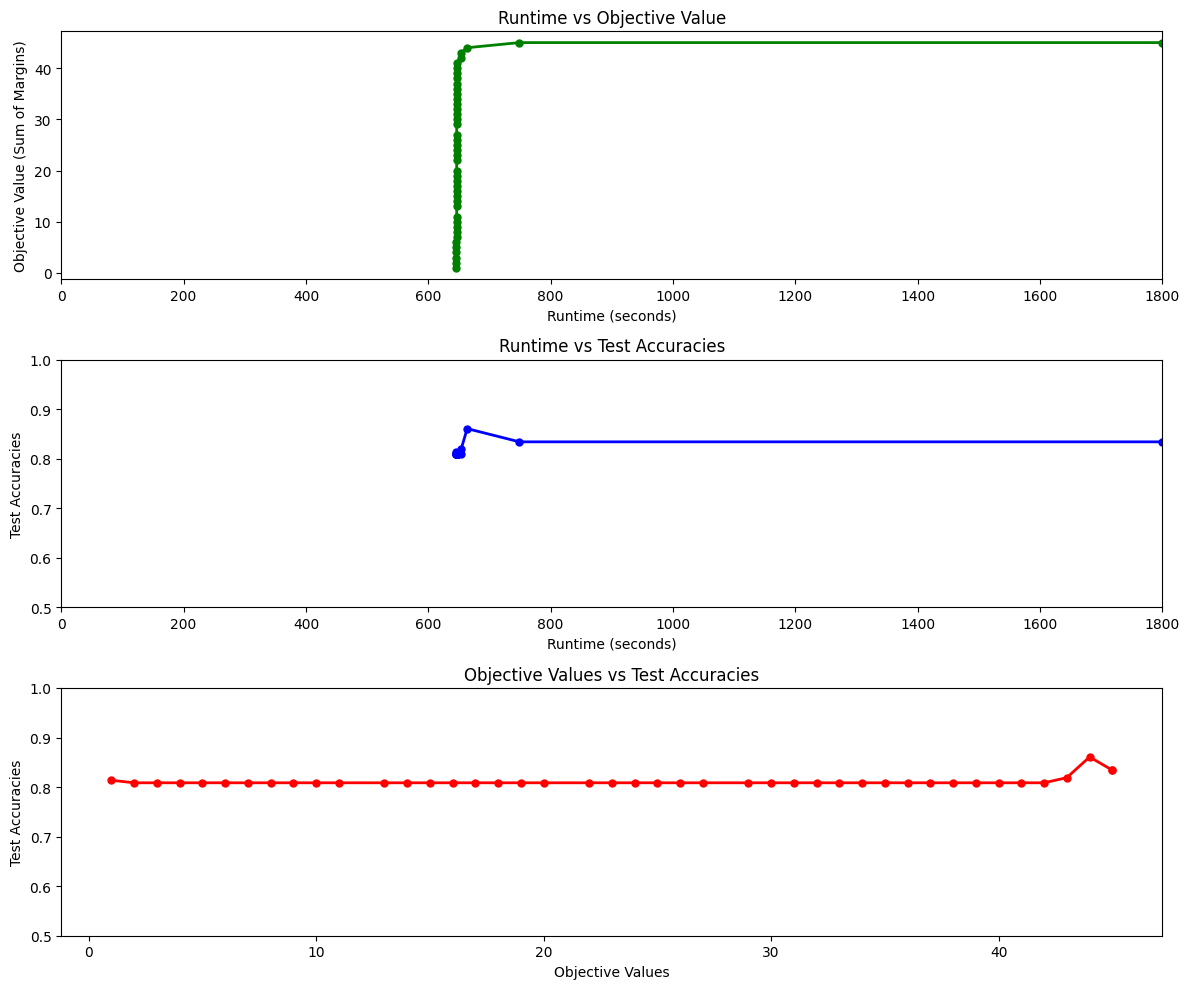

In [35]:
# Append the last point to extend up to runtime 1800
extended_runtime = 1800
runtimes.append(extended_runtime)
objective_vals.append(objective_vals[-1])
test_acc.append(test_acc[-1])

# Increase the figure size
plt.figure(figsize=(12, 10))

# Subplot 1: Runtime vs Objective Values
plt.subplot(3, 1, 1)
plt.plot(runtimes, objective_vals, color='green', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Objective Value (Sum of Margins)")
plt.title("Runtime vs Objective Value")
plt.xlim(0, 1800)

# Subplot 2: Runtime vs Test Accuracies
plt.subplot(3, 1, 2)
plt.plot(runtimes, test_acc, color='blue', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Test Accuracies")
plt.title("Runtime vs Test Accuracies")
plt.ylim(0.5, 1.0)
plt.xlim(0, 1800)

# Subplot 3: Objective Values vs Test Accuracies
plt.subplot(3, 1, 3)
plt.plot(objective_vals, test_acc, color='red', marker='o', linewidth=2, markersize=5)
plt.xlabel("Objective Values")
plt.ylabel("Test Accuracies")
plt.title("Objective Values vs Test Accuracies")
plt.ylim(0.5, 1.0)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

#### Higher Training Accuracy Constraint 

In [36]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

max_margin_mdl = CpoModel(name='Mushroom CP Model 2')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_margin_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

#activations and weights for first hidden layer
activations_1 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for further hidden layers
for l in range(2, L):
    activations_l = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights for output layer
activations_L = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [max_margin_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        
    if N[L]==1: #if output label has a single dimension
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
max_margin_mdl.add(max_margin_mdl.sum(corr_pred)==x_train.shape[0]) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables


# Define the objective
max_margin_obj = max_margin_mdl.integer_var(0, 10000, name='max_margin_objective')
margins_neurons = []
sum_margins = 0
for l in range(1,L+1):
    margins_l = []
    sum_margins_l = 0
    for j in range(N[l]):
        activations_j = []
        margin_j = 0
        for k in range(x_train.shape[0]):
            elem = max_margin_mdl.scal_prod(weights[l-1][j], activations[l-1][k])
            activations_j.append(max_margin_mdl.abs(elem))
        margin_j = max_margin_mdl.min(activations_j)
        margins_l.append(margin_j)
    sum_margins_l += max_margin_mdl.sum(margins_l)
    sum_margins += sum_margins_l

max_margin_mdl.add(max_margin_obj == sum_margins)
max_margin_mdl.add(max_margin_mdl.maximize(max_margin_obj))

#breaking symmetry for weights of first layer
for i in range(N[1]-1):
    max_margin_mdl.add(max_margin_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Start interactive search
max_margin_solutions = max_margin_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')
#max_margin_solution = max_margin_mdl.solve(SearchType='Restart', TimeLimit=1800, LogVerbosity='Terse')

[70, 2, 1]


In [37]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = max_margin_solutions.next()
except StopIteration:
    solution = None

#for each solution, print objective value and test accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test) #compute output activations (predictions) of test set
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values) #compute test accuracy and number of misclassified test exampes
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_margin_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_margin_solutions.end_search()

print("Search ended successfully.")

Objective value: 2 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (69.5,) , Test accuracy: 0.880235010545345
Objective value: 3 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (46,) , Test accuracy: 0.880235010545345
Objective value: 5 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (27.2,) , Test accuracy: 0.880235010545345
Objective value: 7 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (19.1429,) , Test accuracy: 0.880235010545345
Objective value: 8 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (16.625,) , Test accuracy: 0.880235010545345
Objective value: 10 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (13.1,) , Test accuracy: 0.880235010545345
Objective value: 12 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (10.75,) , Test accuracy: 0.880235010545345
Objective value: 13 , No. of solutions found: 8 I

In [38]:
#evaluating exact train accuracy of last obtained solution
max_margin_solution = max_margin_solutions.get_last_result()
train_acc2=0
for k in range(x_train.shape[0]):
    train_acc2+=max_margin_solution.get_value(f'corr_pred_{k}')
print(train_acc2*100/x_train.shape[0])

100.0


In [39]:
#Compute Activations for Dataset x
def compute_activations(weights_solution, x):
    activations = [x.values]  # Use the test set features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx

flatten = lambda l: [item for sublist in l for item in sublist]

# Extract the Weights from the last Solution obtained
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([max_margin_solution[weight_var] for weight_var in neuron_weights]) 

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_test)

# Compute test accuracy and number of misclassified test examples
test_accuracy,incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs))

Test Accuracy: 0.90147634829768
654


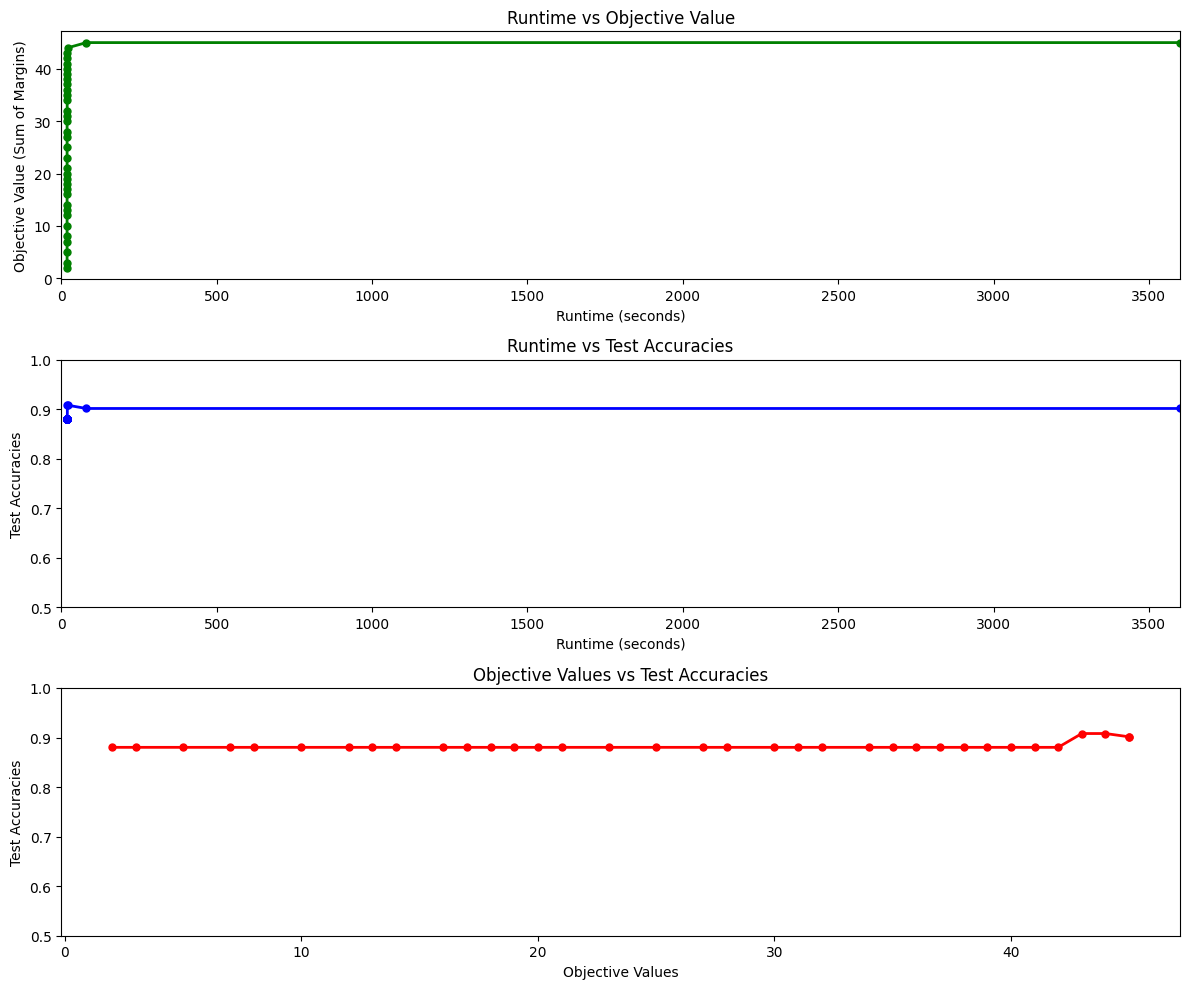

In [40]:
# Append the last point to extend up to runtime limit
extended_runtime = 3600
runtimes.append(extended_runtime)
objective_vals.append(objective_vals[-1])
test_acc.append(test_acc[-1])

# Increase the figure size
plt.figure(figsize=(12, 10))

# Subplot 1: Runtime vs Objective Values
plt.subplot(3, 1, 1)
plt.plot(runtimes, objective_vals, color='green', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Objective Value (Sum of Margins)")
plt.title("Runtime vs Objective Value")
plt.xlim(0, 3600)

# Subplot 2: Runtime vs Test Accuracies
plt.subplot(3, 1, 2)
plt.plot(runtimes, test_acc, color='blue', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Test Accuracies")
plt.title("Runtime vs Test Accuracies")
plt.ylim(0.5, 1.0)
plt.xlim(0, 3600)

# Subplot 3: Objective Values vs Test Accuracies
plt.subplot(3, 1, 3)
plt.plot(objective_vals, test_acc, color='red', marker='o', linewidth=2, markersize=5)
plt.xlabel("Objective Values")
plt.ylabel("Test Accuracies")
plt.title("Objective Values vs Test Accuracies")
plt.ylim(0.5, 1.0)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

### Maximum Accuracy Model

In this model, the objective function used is the training accuracy, i.e

$$\max \left( \frac{\sum_{k=1}^{|\mathcal{T}|}c_k }{|\mathcal{T}|} \right)$$
where $c_k$ is a boolean variable with value 1 indicating correct classification of example $k$ of the training set, and value 0 indicating misclassification of example $k$.

In [77]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))

max_acc_mdl = CpoModel(name='German Credit CP Model 3')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

activations.append(activations_L)
weights.append(weights_L)

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<0.95*x_train.shape[0]) #constraint to prevent overfitting: training accuracy less than 95%


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            

for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
max_acc_solution = max_acc_mdl.solve(SearchType='Restart', TimeLimit=1800, Workers=1, LogVerbosity='Quiet')

print("Final solution:")
print("Objective value:", max_acc_solution.get_objective_value())
print("Is solution optimal:", max_acc_solution.is_solution_optimal())
print("Solver Infos:",max_acc_solution.get_solver_infos())

[70, 2, 1]
Final solution:
Objective value: 94
Is solution optimal: True
Solver Infos: {'DepthFirstIdleTime': 0, 'EffectiveDepthFirstWorkers': 0, 'EffectiveIterativeDivingWorkers': 0, 'EffectiveMultiPointWorkers': 0, 'EffectiveOptimalityTolerance': 0.0094, 'EffectiveRestartWorkers': 1, 'EffectiveWorkers': 1, 'ExtractionTime': 0.01, 'FailStatus': 'SearchHasFailedNormally', 'IterativeDivingIdleTime': 0, 'MemoryUsage': 13535371, 'MultiPointIdleTime': 0, 'NumberOfAuxiliaryVariables': 0, 'NumberOfBranches': 352521, 'NumberOfChoicePoints': 213799, 'NumberOfConstraints': 3902, 'NumberOfConstraintsAdded': 0, 'NumberOfConstraintsAggregated': 3, 'NumberOfConstraintsGenerated': 0, 'NumberOfConstraintsRemoved': 0, 'NumberOfCriteria': 1, 'NumberOfEngineConstraints': 605, 'NumberOfEngineVariables': 4694, 'NumberOfErrors': 0, 'NumberOfFails': 139884, 'NumberOfIntegerVariables': 3842, 'NumberOfIntervalVariables': 0, 'NumberOfModelVariables': 3842, 'NumberOfPresolveTransformations': 3, 'NumberOfSequenc

In [75]:
# Step 1: Extract the Weights from the Solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([max_acc_solution[weight_var] for weight_var in neuron_weights])

# Step 2: Compute Activations for Test Set
def compute_activations(weights_solution, x_test):
    activations = [x_test.values]  # Use the test set features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx

flatten = lambda l: [item for sublist in l for item in sublist]
test_accuracy,incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs),"incorrectly classified examples out of",y_test.shape[0],"test examples")

Test Accuracy: 0.8853570352515818
761 incorrectly classified examples out of 6638 test examples


### Minimum Weight Model

In this model, the objective function used is the sum of absolute weights, i.e

$$\min \sum_{\ell \in \{1,\ldots,L\}} \sum_{i \in N_{\ell - 1}} \sum_{j \in N_{\ell}} |w_{i\ell j}|$$

where $w_{i\ell j}$ denotes the weight of the connection between neuron $j$ of layer $\ell$ to neuron $i$ from layer $\ell - 1$. 

In [151]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

#activations and weights for hidden layers and output layer
activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        
    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.9*x_train.shape[0]) # constraint for minimum training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


#define the objective 
min_weight_obj = min_weight_mdl.integer_var(10, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))

# Solve the model
min_weight_solution = min_weight_mdl.solve(SearchType='Restart', TimeLimit=1800, LogVerbosity='Terse')

print("Final solution:")
print("Objective value:", min_weight_solution.get_objective_value())
print("Is solution optimal:", min_weight_solution.is_solution_optimal())
print("Solver Infos:",min_weight_solution.get_solver_infos())

[70, 2, 1]
 ! --------------------------------------------------- CP Optimizer 20.1.0.0 --
 ! Minimization problem - 3843 variables, 3902 constraints
 ! Presolve      : 1 extractable eliminated
 ! TimeLimit            = 1800
 ! Workers              = 12
 ! LogVerbosity         = Terse
 ! SearchType           = Restart
 ! Initial process time : 0.02s (0.02s extraction + 0.00s propagation)
 !  . Log search space  : 432.1 (before), 432.1 (after)
 !  . Memory usage      : 3.2 MB (before), 3.2 MB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0       3843                 -
 + New bound is 10
 *            10     355k  22.48s      11      (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective         : 10 (optimal - effective to

In [152]:
#compute exact training accuracy of last obtained solution
train_acc=0
for k in range(x_train.shape[0]):
    train_acc+=min_weight_solution.get_value(f'corr_pred_{k}')
print(train_acc*100/x_train.shape[0])

92.0


In [153]:
# Step 1: Extract the Weights from the Solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([min_weight_solution[weight_var] for weight_var in neuron_weights])

# Step 2: Compute Activations for Test Set
def compute_activations(weights_solution, x_test):
    activations = [x_test.values]  # Use the test set features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx


flatten = lambda l: [item for sublist in l for item in sublist]
test_accuracy,incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs),"incorrectly classified examples out of",y_test.shape[0],"test examples")

Test Accuracy: 0.8791804760470021
802 incorrectly classified examples out of 6638 test examples


##### Training Accuracy=100%

In [118]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

#activations and weights for hidden layers and output layer
activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        
    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)==x_train.shape[0]) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))

# Solve the model
min_weight_solution = min_weight_mdl.solve(SearchType='Restart', TimeLimit=1800, LogVerbosity='Terse')

print("Final solution:")
print("Objective value:", min_weight_solution.get_objective_value())
print("Is solution optimal:", min_weight_solution.is_solution_optimal())
print("Solver Infos:",min_weight_solution.get_solver_infos())

[70, 2, 1]
 ! --------------------------------------------------- CP Optimizer 20.1.0.0 --
 ! Minimization problem - 3843 variables, 3902 constraints
 ! TimeLimit            = 1800
 ! Workers              = 12
 ! LogVerbosity         = Terse
 ! SearchType           = Restart
 ! Initial process time : 0.02s (0.02s extraction + 0.00s propagation)
 !  . Log search space  : 332.2 (before), 332.2 (after)
 !  . Memory usage      : 3.2 MB (before), 3.2 MB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0       3843                 -
 + New bound is 0
                        0        243    1            -
 + New bound is 1
                       48        236    1   F     0 != w_1_2_1
 + New bound is 2
 *            78     113k  5.58s        6      (gap is 97.44%)
 *            77     128k  6.08s        5      (gap is 97.40%)


In [119]:
# Step 1: Extract the Weights from the Solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([min_weight_solution[weight_var] for weight_var in neuron_weights])

# Step 2: Compute Activations for Test Set
def compute_activations(weights_solution, x_test):
    activations = [x_test.values]  # Use the test set features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx


flatten = lambda l: [item for sublist in l for item in sublist]
test_accuracy,incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs),"incorrectly classified examples out of",y_test.shape[0],"test examples")

Test Accuracy: 0.9593250979210606
270 incorrectly classified examples out of 6638 test examples


#### Initializing Solution with Keras Solution for training acc>90

For cases where the solver struggles to find even an initial feasible solution, we try to see if initializing it with the keras obtained weights and activations is useful.

In [70]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

#activations and weights for hidden layers and output layer
activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        
    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.9*x_train.shape[0]) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


min_weight_obj = min_weight_mdl.integer_var(20, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))


# Initialize the solution object
sol = min_weight_mdl.create_empty_solution()

# Add values for corr_pred (ensure this is correct and feasible)
for k in range(x_train.shape[0]):
    sol.set_value(corr_pred[k], correct_prediction_list[k])

# Add values for activations
for l in range(1,L+1):
    for k in range(x_train.shape[0]):
         for j in range(N[l]):
            sol.set_value(activations[l][k][j], int(bin_activations[l][k][j]))

# Add values for weights
for l in range(1,L+1):
    for j in range(N[l]):
        for i in range(N[l - 1]):
            sol.set_value(weights[l - 1][j][i], int(bin_weights_keras[l-1][i][j]))

# Set the starting point
min_weight_mdl.set_starting_point(sol)

# Solve the model
min_weight_solutions = min_weight_mdl.start_search(SearchType='Restart', TimeLimit=1800, Workers=1, LogVerbosity='Quiet')

#print("Final solution:")
#print("Objective value:", min_weight_solution.get_objective_value())
#print("Is solution optimal:", min_weight_solution.is_solution_optimal())
#print("Solver Infos:",min_weight_solution.get_solver_infos())

[64, 10, 1]


In [71]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

CpoSolverException: Exception caught from CP solver: 

Search was stopped after the same time limit of 30 minutes, and no solution was reported, which means that initializing with the keras solution does not help.

#### Using Search Phases

We try experimenting with different search phases and see if any of them helps the solver find a feasible solution or speed up the solving process.

In [77]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

#activations and weights for hidden layers and output layer
activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        
    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.9*x_train.shape[0]) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


min_weight_obj = min_weight_mdl.integer_var(20, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))


# Flatten the nested lists of activation and weight variables
flatten = lambda l: [item for sublist in l for item in sublist]

activations_flat = [flatten(layer) for layer in activations]
weights_flat = [flatten(layer) for layer in weights]


# Define the search phase 1
search_phases = [search_phase(corr_pred,varchooser=min_weight_mdl.select_random_var(),valuechooser=min_weight_mdl.select_random_value())]
for l in range(L, 0, -1):
    search_phases.append(search_phase(activations_flat[l],varchooser=min_weight_mdl.select_largest(min_weight_mdl.var_impact()),valuechooser=min_weight_mdl.select_random_value()))
    search_phases.append(search_phase(weights_flat[l-1],varchooser=min_weight_mdl.select_largest(min_weight_mdl.var_impact()),valuechooser=min_weight_mdl.select_random_value()))


# Define the search phase 2
#search_phases = [search_phase(activations_flat[L])]
#weights_act=[]
#for l in range(L, 0, -1):
    #weights_act = weights_flat[l-1] + activations_flat[l-1]
    #search_phases.append(search_phase(weights_act))


# Add search phases to the model
min_weight_mdl.set_search_phases(search_phases)

# Solve the model
min_weight_solutions = min_weight_mdl.start_search(SearchType='Restart', TimeLimit=1800, Workers=1, LogVerbosity='Quiet')

#print("Final solution:")
#print("Objective value:", min_weight_solution.get_objective_value())
#print("Is solution optimal:", min_weight_solution.is_solution_optimal())
#print("Solver Infos:",min_weight_solution.get_solver_infos())

[64, 10, 1]


In [78]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and test accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

Search ended successfully.


We see that the various combinations of search phases do not help and in fact in this case, the solver isn't able to find even a single solution.

## With Robustness Constraints

We now add robustness constraints to the above models. Robustness is defined with respect to the least important features for the target label. SHAP values are used as the measure of feature importance, and can be replaced by other measures of feature importance.

The perturbation set is defined as:

$$ S_\epsilon (x) = \{y \in \mathcal{T}| y[{ \mathcal{F}\backslash \mathcal{F}_{least}}] = x[{ \mathcal{F}\backslash \mathcal{F}_{least}}], ||x-y||_H = 1 \}$$

where $||x-y||_H$ denotes the Hamming distance.

The definition of robustness implies that $\forall y \in S_\epsilon(x), F(y)=F(x)$, where $F(x)$ denotes the output (prediction) of the BNN for input $x$. 

OBSERVATION: $\forall \ell \in \{1,\ldots,L\}, n_\ell (x) = n_\ell (y) \implies n_{\ell+1}(x) = n_{\ell+1}(y)$. 

So, the robustness constraint can be simplified to: $\forall y \in S_\epsilon(x), n_1(y)=n_1(x)$.

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


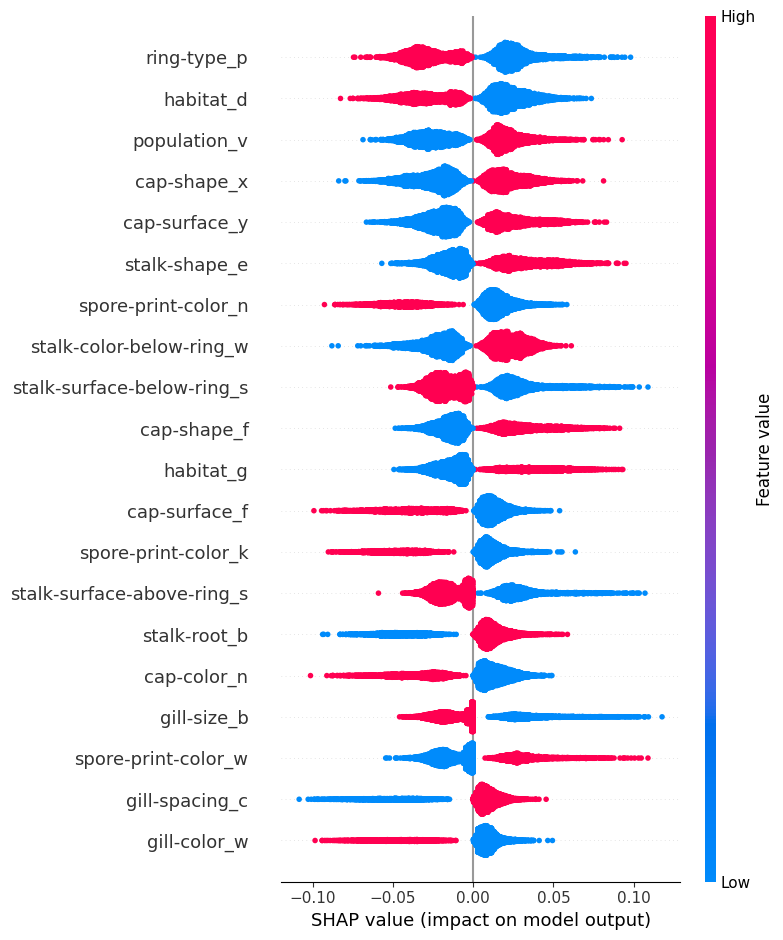

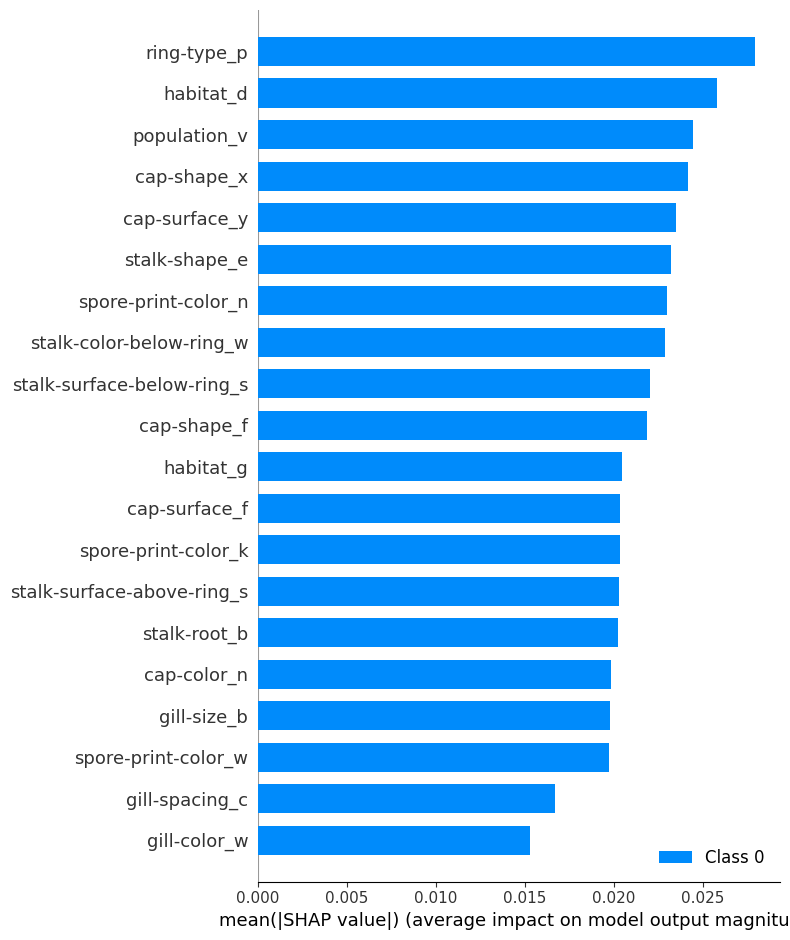

In [42]:
model = load_model('best_model.h5')

# Initialize the SHAP DeepExplainer with the model and the training data
explainer = shap.GradientExplainer(model, x_train.to_numpy())  

# Compute SHAP values for the test set
shap_values = explainer.shap_values(x_test.to_numpy())

# Visualize the SHAP values for a single prediction
shap.summary_plot(shap_values[0], x_test.to_numpy(), feature_names=x_train.columns.tolist())  # This plots the SHAP values for the first class

# Visualize the SHAP values for all predictions
shap.summary_plot(shap_values, x_test.to_numpy(), feature_names=x_train.columns.tolist())

In [43]:
shap_values_array = np.array(shap_values)

# Sum the absolute SHAP values across all samples for each feature
# Here we consider the first output (shap_values[0])
mean_abs_shap_values = np.mean(np.abs(shap_values_array[0]), axis=0)

# Get the feature names 
feature_names = x_train.columns.tolist() 

# Get the indices of the sorted mean absolute SHAP values
sorted_indices = np.argsort(mean_abs_shap_values)

mean_abs_shap_values

array([0.00831844, 0.02189079, 0.00508465, 0.02417771, 0.02035436,
       0.0073243 , 0.02349298, 0.01477587, 0.00580022, 0.01984085,
       0.01482475, 0.0063337 , 0.00233833, 0.00617149, 0.00261558,
       0.00535774, 0.00430858, 0.0044582 , 0.01671083, 0.01979733,
       0.00546318, 0.00686463, 0.00323685, 0.01415421, 0.00419866,
       0.00756983, 0.01528035, 0.02322002, 0.02022297, 0.00900051,
       0.00659585, 0.00619985, 0.02030794, 0.00159909, 0.0078525 ,
       0.01389513, 0.0220539 , 0.00157718, 0.00222391, 0.00800542,
       0.00345432, 0.0127405 , 0.0069093 , 0.00189523, 0.00618326,
       0.0042289 , 0.0043934 , 0.02289651, 0.00749295, 0.00756019,
       0.00123346, 0.02795651, 0.00224427, 0.00926019, 0.02034255,
       0.02302482, 0.00212752, 0.01972513, 0.00499664, 0.00472824,
       0.00569185, 0.00539389, 0.0244681 , 0.01508048, 0.02582463,
       0.02048556, 0.00243359, 0.00345893, 0.00953536, 0.00271317])

In [46]:
# Get the n least important features
n = np.where(mean_abs_shap_values<0.003)[0].shape[0]
least_important_indices = sorted_indices[:n]
least_important_features = [feature_names[i] for i in least_important_indices]

print("The",n,"least important features are:", least_important_features)

The 11 least important features are: ['ring-type_n', 'stalk-surface-below-ring_y', 'stalk-surface-above-ring_y', 'stalk-color-below-ring_b', 'spore-print-color_u', 'stalk-color-above-ring_b', 'spore-print-color_b', 'odor_c', 'habitat_l', 'odor_p', 'habitat_w']


In [47]:
x_train.columns

Index(['cap-shape_b', 'cap-shape_f', 'cap-shape_k', 'cap-shape_x',
       'cap-surface_f', 'cap-surface_s', 'cap-surface_y', 'cap-color_e',
       'cap-color_g', 'cap-color_n', 'cap-color_w', 'odor_a', 'odor_c',
       'odor_l', 'odor_p', 'odor_s', 'odor_y', 'gill-attachment_a',
       'gill-spacing_c', 'gill-size_b', 'gill-color_g', 'gill-color_h',
       'gill-color_k', 'gill-color_n', 'gill-color_p', 'gill-color_u',
       'gill-color_w', 'stalk-shape_e', 'stalk-root_b', 'stalk-root_c',
       'stalk-root_e', 'stalk-surface-above-ring_f',
       'stalk-surface-above-ring_s', 'stalk-surface-above-ring_y',
       'stalk-surface-below-ring_f', 'stalk-surface-below-ring_k',
       'stalk-surface-below-ring_s', 'stalk-surface-below-ring_y',
       'stalk-color-above-ring_b', 'stalk-color-above-ring_g',
       'stalk-color-above-ring_n', 'stalk-color-above-ring_p',
       'stalk-color-above-ring_w', 'stalk-color-below-ring_b',
       'stalk-color-below-ring_g', 'stalk-color-below-ring_n',

We now need to ensure validity of the examples constructed for the perturbation set. To do so, we first create a list of lists consisting of column names corresponding to each feature name.

In [48]:
# Group columns by their prefix
feature_groups = {}
for column in x_train.columns.tolist():
    feature_prefix = column.rsplit('_', 1)[0]  # Get the prefix before the last '_'
    if feature_prefix not in feature_groups:
        feature_groups[feature_prefix] = []
    feature_groups[feature_prefix].append(column)

# Convert the dictionary to a list of lists
feature_list = list(feature_groups.values())

print(feature_list)

[['cap-shape_b', 'cap-shape_f', 'cap-shape_k', 'cap-shape_x'], ['cap-surface_f', 'cap-surface_s', 'cap-surface_y'], ['cap-color_e', 'cap-color_g', 'cap-color_n', 'cap-color_w'], ['odor_a', 'odor_c', 'odor_l', 'odor_p', 'odor_s', 'odor_y'], ['gill-attachment_a'], ['gill-spacing_c'], ['gill-size_b'], ['gill-color_g', 'gill-color_h', 'gill-color_k', 'gill-color_n', 'gill-color_p', 'gill-color_u', 'gill-color_w'], ['stalk-shape_e'], ['stalk-root_b', 'stalk-root_c', 'stalk-root_e'], ['stalk-surface-above-ring_f', 'stalk-surface-above-ring_s', 'stalk-surface-above-ring_y'], ['stalk-surface-below-ring_f', 'stalk-surface-below-ring_k', 'stalk-surface-below-ring_s', 'stalk-surface-below-ring_y'], ['stalk-color-above-ring_b', 'stalk-color-above-ring_g', 'stalk-color-above-ring_n', 'stalk-color-above-ring_p', 'stalk-color-above-ring_w'], ['stalk-color-below-ring_b', 'stalk-color-below-ring_g', 'stalk-color-below-ring_n', 'stalk-color-below-ring_p', 'stalk-color-below-ring_w'], ['ring-number_t'], 

In [49]:
def find(f): #function to find the index of sublist containing feature f
    for i, feature in enumerate(feature_list):
        try:
            j = feature.index(f)
        except ValueError:
            continue
        yield i, j


idx_least = [x_train.columns.get_loc(f) for f in least_important_features] #indices corresponding to least important features

pert = [] #list containing all possible examples in perturbation sets of all examples in the training set
for k in range(x_train.shape[0]):
    pert_k = [] #sublist defining the perturbation set of training example k
    for idx in idx_least: #for each of the least important features, define an example in the perturbation set by changing the bit value of the feature (only one feature at a time)
        x_lst = []
        x_lst = x_train.iloc[k].tolist()
        if x_lst[idx]==-1:
            x_lst[idx]=1
        elif x_lst[idx]==1:
            x_lst[idx]=-1
        
        for f in least_important_features: #check validity of each example before adding it to the perturbation set
            idx_lst = [x_train.columns.get_loc(feature) for feature in feature_list[next(find(f))[0]]] #list containing indices of all columns corresponding to feature f
            elem_lst = [x_lst[i] for i in idx_lst] #list containing values in columns corresponding to feature f
            if sum(elem_lst)<=1 and x_lst not in pert_k: #a valid example can have a value 1 in atmost one column out of all columns corresponding to a particular feature
                pert_k.append(x_lst) #add the example if it is valid and not already included in the perturbation set
    pert.append(pert_k)

print(pert)

[[[-1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1], [-1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1], [-1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1], [-1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -

We now check for contradictory examples (i.e examples encountered while constructing a perturbation set that already exist in the training set with a different label) and discard them.

In [50]:
x_train_list = x_train.values.tolist()
for k in range(x_train.shape[0]):
    for x in pert[k]:
        if x in x_train_list and y_train.iloc[k]!=y_train.iloc[x_train_list.index(x)]: #if the perturbed example already exists in the training set but with a different label, we discard it.
            print("removing element from pert set of x",k)
            pert[k].remove(x)

Finally, we also check the count of examples in the perturbation sets that exist in the training set.

In [51]:
count=0
for k in range(x_train.shape[0]):
    for elem in pert[k]:
        if elem in x_train.values.tolist():
            count+=1
count

0

Having defined the collection of perturbation sets of the training examples, we now add the robustness constraints to each of the three models.

### Maximum Margin Model

In [ ]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))

max_margin_mdl = CpoModel(name='German Credit CP Model 2')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] 
#constraint for activations of input layer to be equal to feature values of input samples
for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_margin_mdl.add(activations_0[k][j] == x_train.iloc[k][j])

activations.append(activations_0)

#define the input layer activations for the list of perturbation sets of the training set
activations_0_pert = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                max_margin_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i])


activations_1 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)] #activations of the first layer neurons for the training examples
weights_1 = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)] #incoming weights from input layer neurons to first layer neurons
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first layer activations for the list of perturbation sets of the training examples
activations_1_pert = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]: #if valid perturbed examples for input k exist
        for j in range(len(pert[k])):
            for i in range(N[1]):
                max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1)) #definition of activations of layer 1 neurons
                max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                max_margin_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i])) #robustness constraint: activations of first layer neurons for all examples in the perturbation set should be same as the activations for the training example itself

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    weights_l = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

# activations and incoming weights for last layer
activations_L = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [max_margin_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #correct_prediction_condition = max_margin_mdl.logical_and([activations_l[k][j] == y_train.iloc[k][j] for j in range(N[l])]) 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
max_margin_mdl.add((max_margin_mdl.sum(corr_pred)>0.8*x_train.shape[0]) & (max_margin_mdl.sum(corr_pred)<x_train.shape[0])) # constraint for minimum training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables

# Define the objective
max_margin_obj = max_margin_mdl.integer_var(0, 10000, name='max_margin_objective')
margins_neurons = []
sum_margins = 0
for l in range(1,L+1):
    margins_l = []
    sum_margins_l = 0
    for j in range(N[l]):
        activations_j = []
        margin_j = 0
        for k in range(x_train.shape[0]):
            elem = max_margin_mdl.scal_prod(weights[l-1][j], activations[l-1][k])
            activations_j.append(max_margin_mdl.abs(elem))
        margin_j = max_margin_mdl.min(activations_j)
        margins_l.append(margin_j)
    sum_margins_l += max_margin_mdl.sum(margins_l)
    sum_margins += sum_margins_l

max_margin_mdl.add(max_margin_obj == sum_margins)
max_margin_mdl.add(max_margin_mdl.maximize(max_margin_obj))

for i in range(N[1]-1):
    max_margin_mdl.add(max_margin_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Start interactive search
max_margin_solutions = max_margin_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[70, 2, 1]


In [ ]:
def compute_activations(weights_solution, x_test):
    activations = [x_test.values]  # Use the test set features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx

# Assume y_test is your true labels for the test set
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
# Print intermediate solutions
objective_vals = [] #list for storing objective values of all solutions
runtimes = [] #list for storing runtimes of all solutions
numsols = []
test_acc = [] #list for storing test accuracies of all solutions

# Fetch the first solution
try:
    solution = max_margin_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and test accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_margin_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_margin_solutions.end_search()

print("Search ended successfully.")

Objective value: 3 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (46,) , Test accuracy: 0.7893943959023803
Objective value: 4 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (34.25,) , Test accuracy: 0.7893943959023803
Objective value: 5 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (27.2,) , Test accuracy: 0.7865320879783068
Objective value: 6 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (22.5,) , Test accuracy: 0.7865320879783068
Objective value: 7 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (19.1429,) , Test accuracy: 0.7865320879783068
Objective value: 8 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (16.625,) , Test accuracy: 0.7865320879783068
Objective value: 9 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (14.6667,) , Test accuracy: 0.7865320879783068
Objective value: 10 , No. of solutions fo

In [55]:
#computing the exact training accuracy of the robust max margin model
max_margin_solution = max_margin_solutions.get_last_solution()
train_acc1=0
for k in range(x_train.shape[0]):
    train_acc1+=max_margin_solution.get_value(f'corr_pred_{k}')
print(train_acc1*100/x_train.shape[0])

96.0


In [56]:
# computing the test accuracy and number of misclassified test examples

# Step 1: Extract the Weights from the Solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([max_margin_solution[weight_var] for weight_var in neuron_weights])

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_test)

test_accuracy,incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs),"incorrectly classified examples out of",y_test.shape[0],"test examples")

Test Accuracy: 0.8258511599879482
1156 incorrectly classified examples out of 6638 test examples


##### Plots for Performance of Max Margin Model

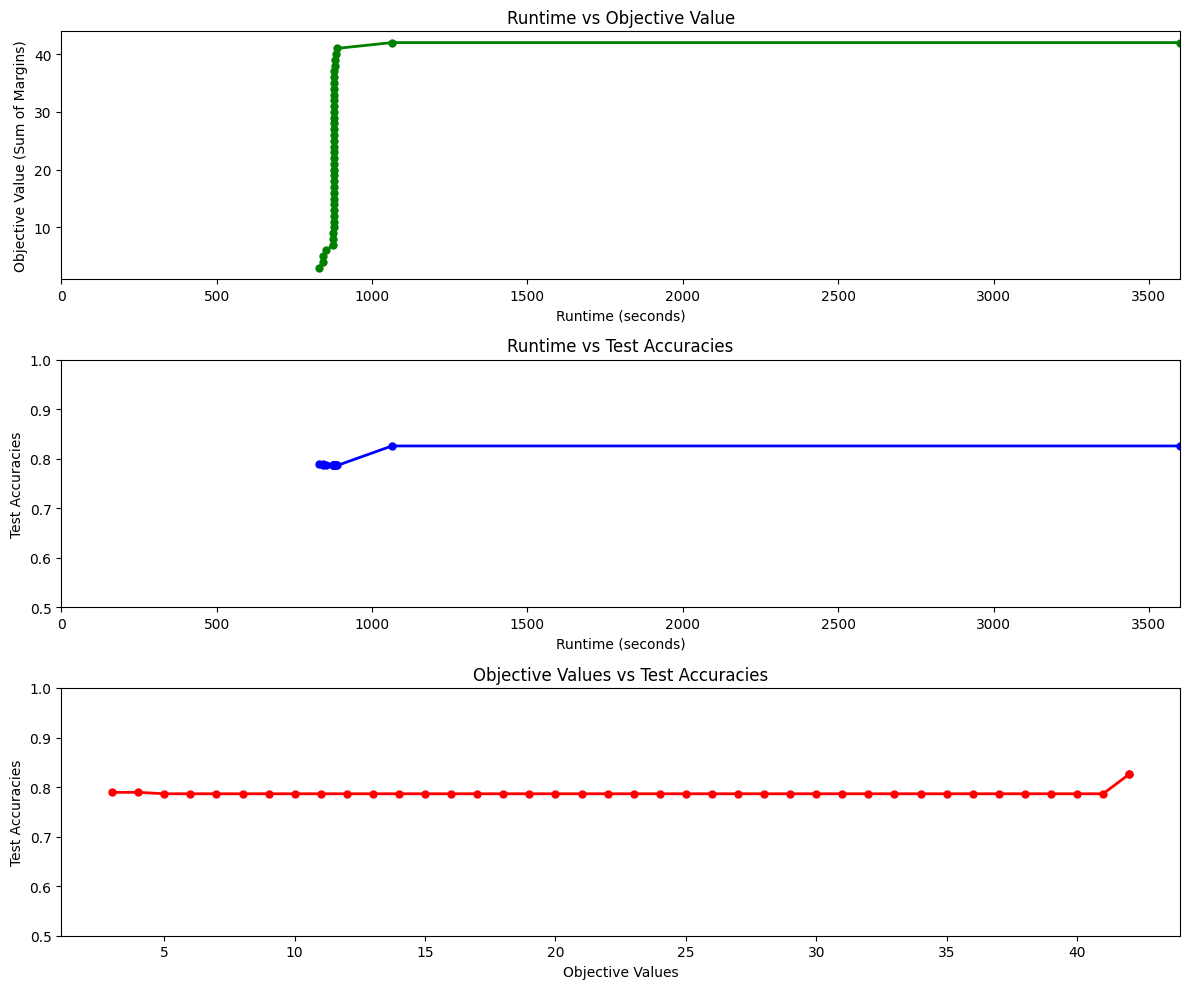

In [57]:
# Append the last point to extend up to runtime 3600
extended_runtime = 3600
runtimes.append(extended_runtime)
objective_vals.append(objective_vals[-1])
test_acc.append(test_acc[-1])

# Increase the figure size
plt.figure(figsize=(12, 10))

# Subplot 1: Runtime vs Objective Values
plt.subplot(3, 1, 1)
plt.plot(runtimes, objective_vals, color='green', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Objective Value (Sum of Margins)")
plt.title("Runtime vs Objective Value")
plt.xlim(0, 3600)

# Subplot 2: Runtime vs Test Accuracies
plt.subplot(3, 1, 2)
plt.plot(runtimes, test_acc, color='blue', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Test Accuracies")
plt.title("Runtime vs Test Accuracies")
plt.ylim(0.5, 1.0)
plt.xlim(0, 3600)

# Subplot 3: Objective Values vs Test Accuracies
plt.subplot(3, 1, 3)
plt.plot(objective_vals, test_acc, color='red', marker='o', linewidth=2, markersize=5)
plt.xlabel("Objective Values")
plt.ylabel("Test Accuracies")
plt.title("Objective Values vs Test Accuracies")
plt.ylim(0.5, 1.0)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

### Minimum Weight Model

In [123]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

#activations of input layer for list of perturbation sets of the training examples
activations_0_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                min_weight_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i])

#activations of neurons of first layer for training examples 
activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)] #incoming weights to first layer neurons
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations of first layer neurons for perturbed examples
activations_1_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]: #if 
        for j in range(len(pert[k])):
            for i in range(N[1]):
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                min_weight_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i]))


#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights of last layer
activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add((min_weight_mdl.sum(corr_pred)>0.9*x_train.shape[0])) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


# Flatten the nested lists of activation and weight variables
#flatten = lambda l: [item for sublist in l for item in sublist]

#activations_flat = [flatten(layer) for layer in activations]
#weights_flat = [flatten(layer) for layer in weights]

#define the objective
min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))

#start interactive search
min_weight_solutions = min_weight_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

#print("Final solution:")
#print("Objective value:", min_weight_solution.get_objective_value())
#print("Is solution optimal:", min_weight_solution.is_solution_optimal())
#print("Solver Infos:",min_weight_solution.get_solver_infos())

[70, 2, 1]


In [124]:
# Print intermediate solutions
objective_vals = [] #list for storing objective values of all solutions
runtimes = [] #list for storing runtimes of all solutions
numsols = []
test_acc = [] #list for storing test accuracies of all solutions

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and test accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

Search ended successfully.


We observe that no solutions were found within the time limit. We now experiment with different search phases and see if any combination helps the solver find a feasible solution within the time limit.

#### Using Search Phases

In [125]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

activations_0_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                min_weight_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i])


activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

activations_1_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[1]):
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                min_weight_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i]))


#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add((min_weight_mdl.sum(corr_pred)>0.9*x_train.shape[0])) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


# Flatten the nested lists of activation and weight variables
flatten = lambda l: [item for sublist in l for item in sublist]

activations_flat = [flatten(layer) for layer in activations]
weights_flat = [flatten(layer) for layer in weights]

# Define the search phase 1
search_phases = []
for l in range(L, 0, -1):
    search_phases.append(search_phase(activations_flat[l]))
    search_phases.append(search_phase(weights_flat[l-1]))


# Define the search phase 2
#search_phases = [search_phase(corr_pred),search_phase(activations_flat[L])]
#weights_act=[]
#for l in range(L, 0, -1):
    #weights_act = weights_flat[l-1] + activations_flat[l-1]
    #search_phases.append(search_phase(weights_act))


# Add search phases to the model
max_acc_mdl.set_search_phases(search_phases)


min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))

min_weight_solutions = min_weight_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[70, 2, 1]


In [126]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

Search ended successfully.


In [127]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

activations_0_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                min_weight_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i])


activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

activations_1_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[1]):
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                min_weight_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i]))


#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add((min_weight_mdl.sum(corr_pred)>0.9*x_train.shape[0])) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


# Flatten the nested lists of activation and weight variables
flatten = lambda l: [item for sublist in l for item in sublist]

activations_flat = [flatten(layer) for layer in activations]
weights_flat = [flatten(layer) for layer in weights]

# Define the search phase 1
#search_phases = []
#for l in range(L, 0, -1):
    #search_phases.append(search_phase(activations_flat[l]))
    #search_phases.append(search_phase(weights_flat[l-1]))


# Define the search phase 2
search_phases = [search_phase(corr_pred),search_phase(activations_flat[L])]
weights_act=[]
for l in range(L, 0, -1):
    weights_act = weights_flat[l-1] + activations_flat[l-1]
    search_phases.append(search_phase(weights_act))


# Add search phases to the model
max_acc_mdl.set_search_phases(search_phases)


min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))

min_weight_solutions = min_weight_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[70, 2, 1]


In [128]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

Search ended successfully.


Hence, we observe that both the search phases do not help. The solver is still unable to find a feasible solution within the time limit for sample size 50.

#### Lower Training Accuracy

We now relax the training accuracy constraint to impose a lower training accuracy.

In [138]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

activations_0_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                min_weight_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i])


activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

activations_1_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[1]):
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                min_weight_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i]))


#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add((min_weight_mdl.sum(corr_pred)>0.8*x_train.shape[0])) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


# Flatten the nested lists of activation and weight variables
flatten = lambda l: [item for sublist in l for item in sublist]

activations_flat = [flatten(layer) for layer in activations]
weights_flat = [flatten(layer) for layer in weights]

# Define the search phase 1
#search_phases = []
#for l in range(L, 0, -1):
    #search_phases.append(search_phase(activations_flat[l]))
    #search_phases.append(search_phase(weights_flat[l-1]))


# Define the search phase 2
#search_phases = [search_phase(corr_pred),search_phase(activations_flat[L])]
#weights_act=[]
#for l in range(L, 0, -1):
    #weights_act = weights_flat[l-1] + activations_flat[l-1]
    #search_phases.append(search_phase(weights_act))


# Add search phases to the model
max_acc_mdl.set_search_phases(search_phases)


min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))

min_weight_solutions = min_weight_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[70, 2, 1]


In [139]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

Objective value: 4 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (0.5,) , Test accuracy: 0.7429948779752937
Objective value: 3 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (0.333333,) , Test accuracy: 0.8335341970473034
Objective value: 2 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (0,) , Test accuracy: 0.7545947574570654
No more solutions available.
Search ended successfully.


In [140]:
min_weight_solution = min_weight_solutions.get_last_solution()
train_acc=0
for k in range(x_train.shape[0]):
    train_acc+=min_weight_solution.get_value(f'corr_pred_{k}')
print(train_acc*100/x_train.shape[0])

82.0


The solver is able to find and optimize the solution in this case.

### Maximum Accuracy Model

In [94]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))

max_acc_mdl = CpoModel(name='German Credit CP Model 3')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #define input layer activations as equal to the input feature value


activations.append(activations_0)

#input layer activations for perturbed examples
activations_0_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                max_acc_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i]) #define input layer activations as equal to the input feature value

#first layer activations for training examples and incoming weights to first layer
activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first layer activations
activations_1_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[1]):
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                max_acc_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i])) #robustness constraint: impose equality of first layer activations of perturbed examples and the first layer activations of example itself


#activations and weights for hidden layers
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights of the last (output) layer
activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
#max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<x_train.shape[0])

activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            
#breaking the symmetry for weights of first layer
for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
#max_acc_solution = max_acc_mdl.solve(SearchType='Restart', TimeLimit=1800, LogVerbosity='Terse')
max_acc_solutions = max_acc_mdl.start_search(SearchType='Restart', TimeLimit=3600, LogVerbosity='Quiet')

[70, 2, 1]


In [95]:
# Print intermediate solutions
objective_vals = [] #list of objective values of all solutions found
runtimes = [] #list of runtime values of all solutions found
numsols = [] 
test_acc = [] #list of test accuracies of all solutions found

# Fetch the first solution
try:
    solution = max_acc_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and test accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test) #compute output layer activations (predictions) for test set
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values) #compute test accuracy and number of misclassified test examples
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_acc_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_acc_solutions.end_search()

print("Search ended successfully.")

Objective value: 50 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (1,) , Test accuracy: 0.4814703223862609
Objective value: 52 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (0.923077,) , Test accuracy: 0.48312744802651403
Objective value: 54 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (0.851852,) , Test accuracy: 0.48357939138294664
Objective value: 58 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (0.724138,) , Test accuracy: 0.5036155468514613
Objective value: 60 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (0.666667,) , Test accuracy: 0.47107562518830975
Objective value: 62 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (0.612903,) , Test accuracy: 0.5429346188611027
Objective value: 64 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (0.5625,) , Test accuracy: 0.5518228382042784
Objective value: 66

In [99]:
max_acc_solution = max_acc_solutions.get_last_solution()
max_acc_solution.get_solver_infos()['TotalTime']

1076.55

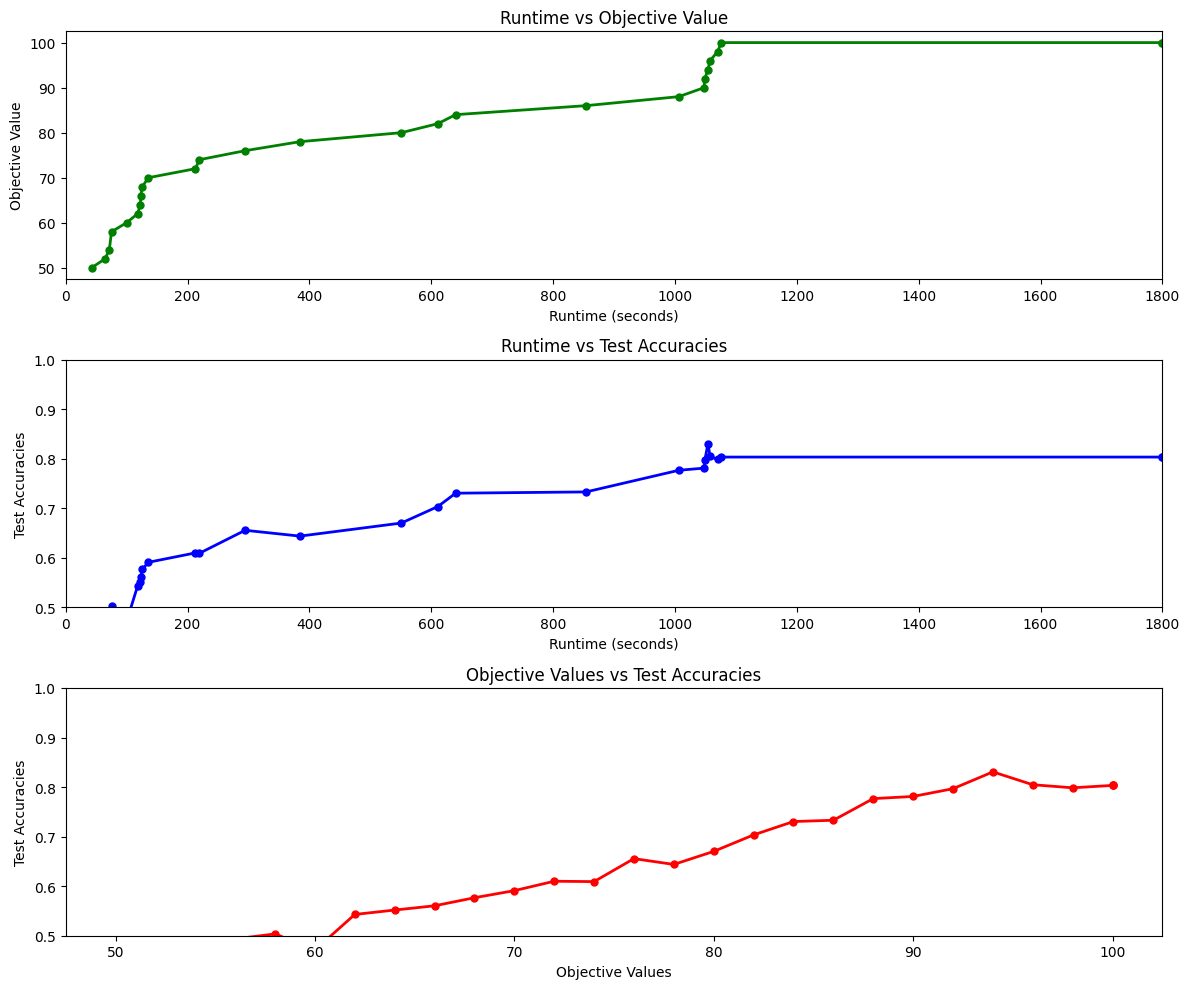

In [97]:
# Append the last point to extend up to runtime limit
extended_runtime = 1800
runtimes.append(extended_runtime)
objective_vals.append(objective_vals[-1])
test_acc.append(test_acc[-1])

# Increase the figure size
plt.figure(figsize=(12, 10))

# Subplot 1: Runtime vs Objective Values
plt.subplot(3, 1, 1)
plt.plot(runtimes, objective_vals, color='green', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Objective Value")
plt.title("Runtime vs Objective Value")
plt.xlim(0, 1800)

# Subplot 2: Runtime vs Test Accuracies
plt.subplot(3, 1, 2)
plt.plot(runtimes, test_acc, color='blue', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Test Accuracies")
plt.title("Runtime vs Test Accuracies")
plt.ylim(0.5, 1.0)
plt.xlim(0, 1800)

# Subplot 3: Objective Values vs Test Accuracies
plt.subplot(3, 1, 3)
plt.plot(objective_vals, test_acc, color='red', marker='o', linewidth=2, markersize=5)
plt.xlabel("Objective Values")
plt.ylabel("Test Accuracies")
plt.title("Objective Values vs Test Accuracies")
plt.ylim(0.5, 1.0)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

#### With Search Phases

##### Search Phase 2

In [85]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))

max_acc_mdl = CpoModel(name='German Credit CP Model 3')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

#input layer activations of perturbed examples
activations_0_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                max_acc_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i]) #definition of input layer activations

#first layer activations of training set
activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first layer activations of perturbed examples
activations_1_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]: #check if set of valid perturbed examples of input k is non-empty
        for j in range(len(pert[k])):
            for i in range(N[1]):
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                max_acc_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i])) #robustness constraint: impose equality of first layer activations of training examples and those of all elements in their perturbed sets


#activations and weights for hidden layers 
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights for output layer
activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
#max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<x_train.shape[0])

activations.append(activations_L)
weights.append(weights_L)

activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables

# Flatten the nested lists of activation and weight variables
flatten = lambda l: [item for sublist in l for item in sublist]

activations_flat = [flatten(layer) for layer in activations]
weights_flat = [flatten(layer) for layer in weights]


# Define the search phase 1
#search_phases = []
#for l in range(L, 0, -1):
    #search_phases.append(search_phase(activations_flat[l]))
    #search_phases.append(search_phase(weights_flat[l-1]))


# Define the search phase 2
search_phases = [search_phase(corr_pred),search_phase(activations_flat[L])]
weights_act=[]
for l in range(L, 0, -1):
    weights_act = weights_flat[l-1] + activations_flat[l-1]
    search_phases.append(search_phase(weights_act))


# Add search phases to the model
max_acc_mdl.set_search_phases(search_phases)


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            

for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
#max_acc_solution = max_acc_mdl.solve(SearchType='Restart', TimeLimit=1800, Workers=1, LogVerbosity='Quiet')
max_acc_solutions = max_acc_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')
#print("Final solution:")
#print("Objective value:", max_acc_solution.get_objective_value())
#print("Is solution optimal:", max_acc_solution.is_solution_optimal())
#print("Solver Infos:",max_acc_solution.get_solver_infos())

[70, 2, 1]


In [86]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = max_acc_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_acc_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_acc_solutions.end_search()

print("Search ended successfully.")

Objective value: 50 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (1,) , Test accuracy: 0.5188309731846942
Objective value: 52 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (0.923077,) , Test accuracy: 0.5388671286532088
Objective value: 54 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (0.851852,) , Test accuracy: 0.5501657125640254
Objective value: 56 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (0.785714,) , Test accuracy: 0.557698101837903
Objective value: 58 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (0.724138,) , Test accuracy: 0.581952395299789
Objective value: 60 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (0.666667,) , Test accuracy: 0.6217234106658632
Objective value: 62 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (0.612903,) , Test accuracy: 0.6571256402530883
Objective value: 64 , 

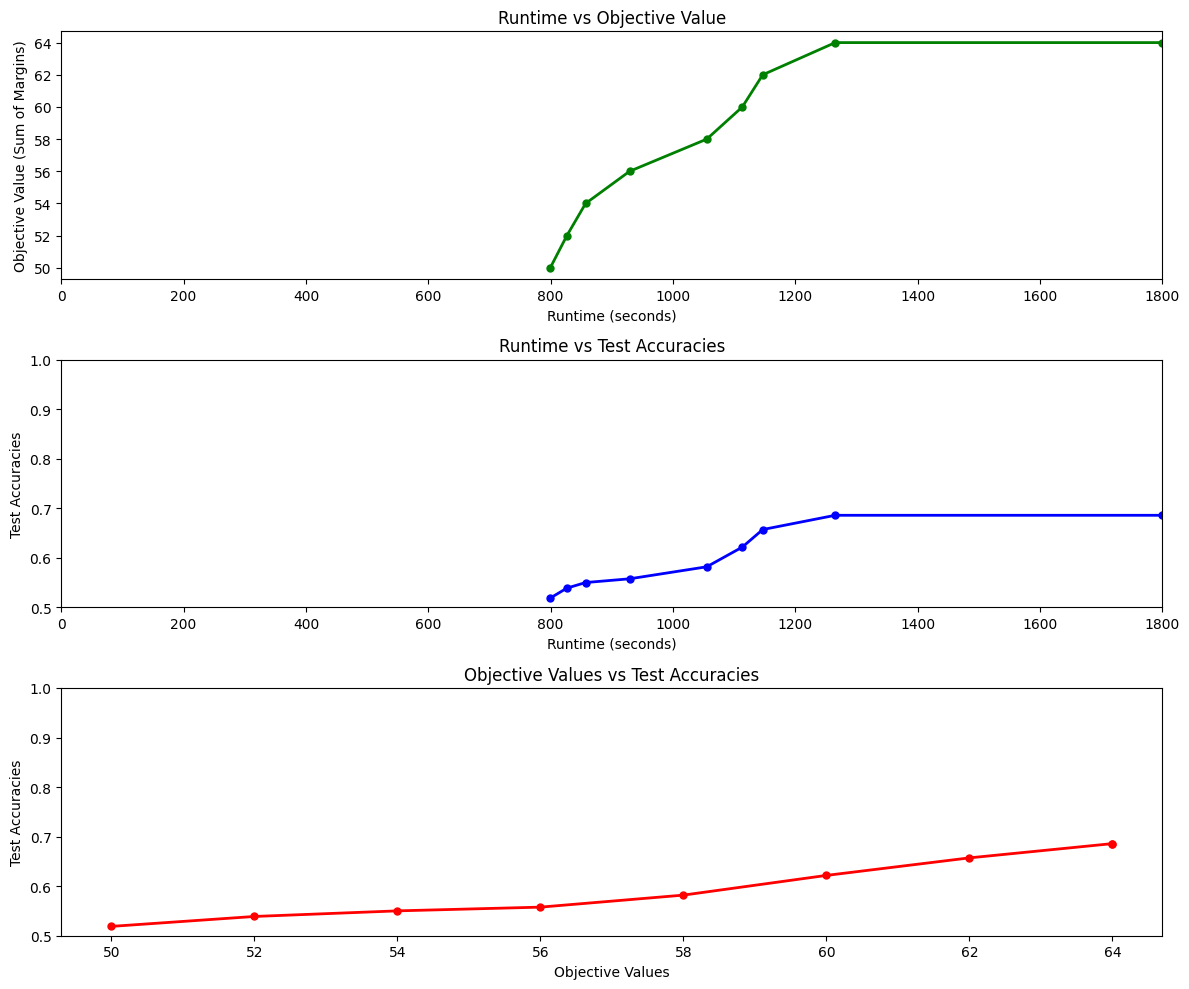

In [90]:
# Append the last point to extend up to runtime 1800
extended_runtime = 1800
runtimes.append(extended_runtime)
objective_vals.append(objective_vals[-1])
test_acc.append(test_acc[-1])

# Increase the figure size
plt.figure(figsize=(12, 10))

# Subplot 1: Runtime vs Objective Values
plt.subplot(3, 1, 1)
plt.plot(runtimes, objective_vals, color='green', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Objective Value (Sum of Margins)")
plt.title("Runtime vs Objective Value")
plt.xlim(0, 1800)

# Subplot 2: Runtime vs Test Accuracies
plt.subplot(3, 1, 2)
plt.plot(runtimes, test_acc, color='blue', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Test Accuracies")
plt.title("Runtime vs Test Accuracies")
plt.ylim(0.5, 1.0)
plt.xlim(0, 1800)

# Subplot 3: Objective Values vs Test Accuracies
plt.subplot(3, 1, 3)
plt.plot(objective_vals, test_acc, color='red', marker='o', linewidth=2, markersize=5)
plt.xlabel("Objective Values")
plt.ylabel("Test Accuracies")
plt.title("Objective Values vs Test Accuracies")
plt.ylim(0.5, 1.0)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

##### Search Phase 1

In [91]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))

max_acc_mdl = CpoModel(name='German Credit CP Model 3')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

#input layer activations of perturbed examples
activations_0_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                max_acc_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i]) #definition of input layer activations

#first layer activations of training set
activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first layer activations of perturbed examples
activations_1_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]: #check if set of valid perturbed examples of input k is non-empty
        for j in range(len(pert[k])):
            for i in range(N[1]):
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                max_acc_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i])) #robustness constraint: impose equality of first layer activations of training examples and those of all elements in their perturbed sets


#activations and weights for hidden layers 
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights for output layer
activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
#max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<x_train.shape[0])

activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables

# Flatten the nested lists of activation and weight variables
flatten = lambda l: [item for sublist in l for item in sublist]

activations_flat = [flatten(layer) for layer in activations]
weights_flat = [flatten(layer) for layer in weights]


# Define the search phase 1
search_phases = [search_phase(corr_pred)]
for l in range(L, 0, -1):
    search_phases.append(search_phase(activations_flat[l]))
    search_phases.append(search_phase(weights_flat[l-1]))


# Define the search phase 2
#search_phases = [search_phase(corr_pred),search_phase(activations_flat[L])]
#weights_act=[]
#for l in range(L, 0, -1):
    #weights_act = weights_flat[l-1] + activations_flat[l-1]
    #search_phases.append(search_phase(weights_act))


# Add search phases to the model
max_acc_mdl.set_search_phases(search_phases)


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            

for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
#max_acc_solution = max_acc_mdl.solve(SearchType='Restart', TimeLimit=1800, Workers=1, LogVerbosity='Quiet')
max_acc_solutions = max_acc_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')
#print("Final solution:")
#print("Objective value:", max_acc_solution.get_objective_value())
#print("Is solution optimal:", max_acc_solution.is_solution_optimal())
#print("Solver Infos:",max_acc_solution.get_solver_infos())

[70, 2, 1]


In [92]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = max_acc_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_acc_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_acc_solutions.end_search()

print("Search ended successfully.")

Objective value: 50 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (1,) , Test accuracy: 0.5174751431153962
Objective value: 52 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (0.923077,) , Test accuracy: 0.532389273877674
Objective value: 54 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (0.851852,) , Test accuracy: 0.5439891533594456
Objective value: 56 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (0.785714,) , Test accuracy: 0.5539319072009642
Objective value: 58 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (0.724138,) , Test accuracy: 0.5989755950587526
Objective value: 60 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (0.666667,) , Test accuracy: 0.602892437481169
Objective value: 62 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (0.612903,) , Test accuracy: 0.6278999698704429
Objective value: 64 , 

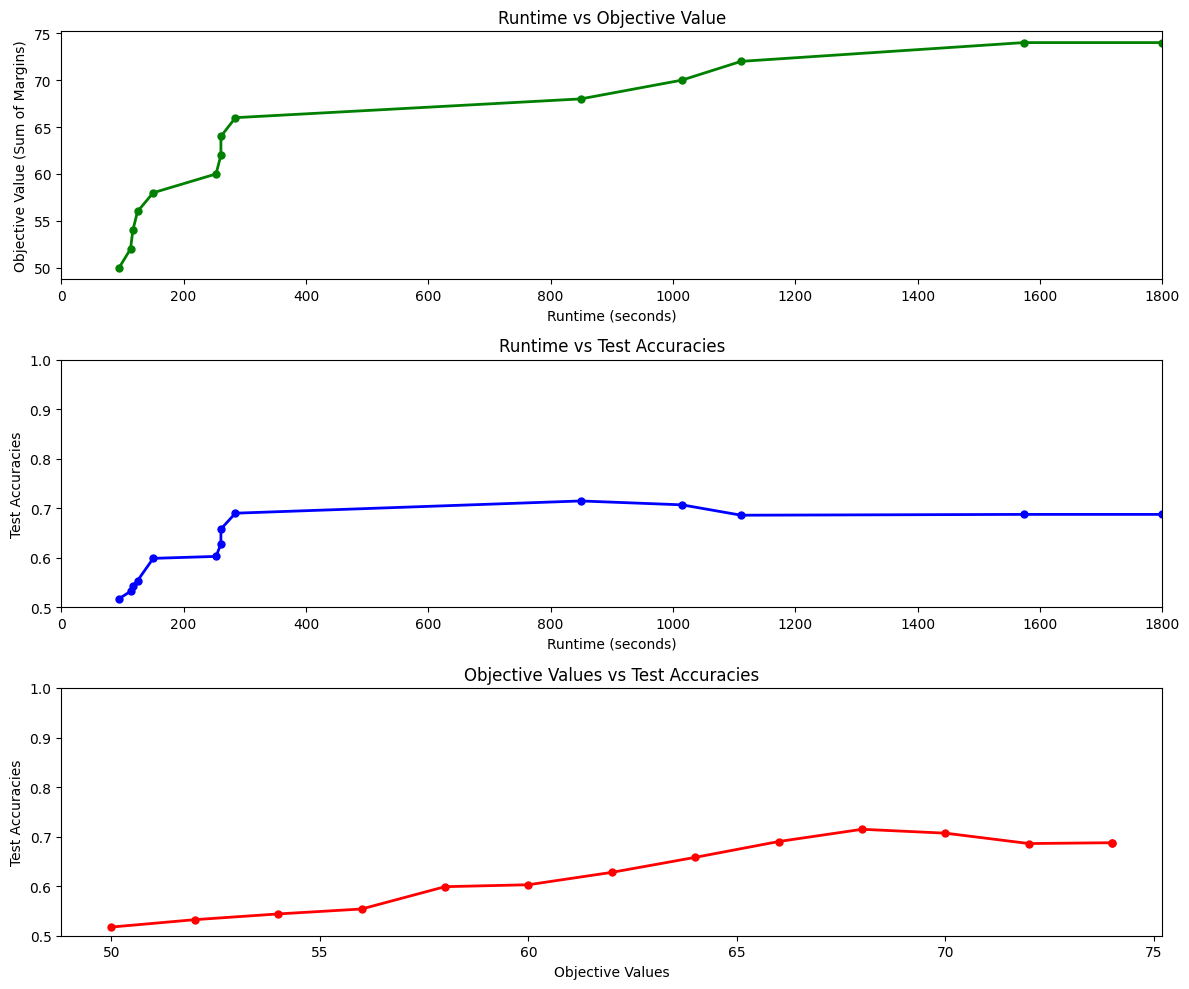

In [93]:
# Append the last point to extend up to runtime 1800
extended_runtime = 1800
runtimes.append(extended_runtime)
objective_vals.append(objective_vals[-1])
test_acc.append(test_acc[-1])

# Increase the figure size
plt.figure(figsize=(12, 10))

# Subplot 1: Runtime vs Objective Values
plt.subplot(3, 1, 1)
plt.plot(runtimes, objective_vals, color='green', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Objective Value (Sum of Margins)")
plt.title("Runtime vs Objective Value")
plt.xlim(0, 1800)

# Subplot 2: Runtime vs Test Accuracies
plt.subplot(3, 1, 2)
plt.plot(runtimes, test_acc, color='blue', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Test Accuracies")
plt.title("Runtime vs Test Accuracies")
plt.ylim(0.5, 1.0)
plt.xlim(0, 1800)

# Subplot 3: Objective Values vs Test Accuracies
plt.subplot(3, 1, 3)
plt.plot(objective_vals, test_acc, color='red', marker='o', linewidth=2, markersize=5)
plt.xlabel("Objective Values")
plt.ylabel("Test Accuracies")
plt.title("Objective Values vs Test Accuracies")
plt.ylim(0.5, 1.0)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

For this search phase, the time at which the first feasible solution is obtained is much lower than for search phase 2 above, however the solver still isn't able to optimize the solution (although the obtained solution is better than the one obtained with search phase 2). So, search phase 1 performs much better than search phase 2, but still worse than the default.

### IMPROVING THE ROBUST MODELS USING THE VALIDATION SET

Through the plots of the test accuracies vs the optimal values of the different models, we make the following observations:
1) The solver often found feasible solutions very fast (within a few seconds) but struggled to optimize or prove optimality of a solution within the time limit. Intermediate solutions, however, perform reasonably well on the test set.
2) The optimal solutions may not always generalize the best, i.e the test accuracies of the optimal or final solutions may not always be the highest.


Moreover, the solutions for all models generalize quite well (with test accuracies often greater than 75-80%) even with extremely small training datasets and absolutely no use of the validation set. On the other hand, the good generalization of the Keras-trained BNN can be attributed to the large validation set used, as observed at the beginning of this notebook. So, in order to improve the generalization of our CPO-trained BNNs, we will make use of the validation set in the following two ways.
1) The validation accuracies of the intermediate solutions are computed and the solution having the best validation accuracy is finally adopted ans is expected to generalize the best (i.e have the highest test accuracy too).
2) For very small training samples, for CP $_{a}$: From the validation set, a few examples that are misclassified by the CPO model are randomly sampled (an equal number from both classes), and more constraints are then added to the model to ensure correct classification of these examples. This process is repeated a few times.

In [63]:
x_val.replace(0,-1,inplace=True)
y_val.replace(0,-1,inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Maximum Margin

In [66]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))

max_margin_mdl = CpoModel(name='German Credit CP Model 2')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] 
#constraint for activations of input layer to be equal to feature values of input samples
for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_margin_mdl.add(activations_0[k][j] == x_train.iloc[k][j])

activations.append(activations_0)

#input layer activations for perturbed examples
activations_0_pert = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                max_margin_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i]) #definition of input layer activations

#first layer activations for training set
activations_1 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first layer activations for perturbed examples
activations_1_pert = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[1]):
                max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                max_margin_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i])) #robustness constraint: first layer activations of perturbed examples should be the same as first layer activations of the example itself

#activations and weights for hidden layers 
for l in range(2, L):
    activations_l = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights for output layer
activations_L = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [max_margin_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #correct_prediction_condition = max_margin_mdl.logical_and([activations_l[k][j] == y_train.iloc[k][j] for j in range(N[l])]) 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
max_margin_mdl.add(max_margin_mdl.sum(corr_pred)>0.9*x_train.shape[0]) # constraint for minimum training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables

# Define the objective
max_margin_obj = max_margin_mdl.integer_var(0, 10000, name='max_margin_objective')
margins_neurons = []
sum_margins = 0
for l in range(1,L+1):
    margins_l = []
    sum_margins_l = 0
    for j in range(N[l]):
        activations_j = []
        margin_j = 0
        for k in range(x_train.shape[0]):
            elem = max_margin_mdl.scal_prod(weights[l-1][j], activations[l-1][k])
            activations_j.append(max_margin_mdl.abs(elem))
        margin_j = max_margin_mdl.min(activations_j)
        margins_l.append(margin_j)
    sum_margins_l += max_margin_mdl.sum(margins_l)
    sum_margins += sum_margins_l

max_margin_mdl.add(max_margin_obj == sum_margins)
max_margin_mdl.add(max_margin_mdl.maximize(max_margin_obj))

#breaking the symmetry for incoming weights of first layer
for i in range(N[1]-1):
    max_margin_mdl.add(max_margin_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Start interactive search
max_margin_solutions = max_margin_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[70, 2, 1]


In [67]:
# Initialize variables to store the best solution
objective_vals = [] #list containing objective values of all solutions found
runtimes = [] #list containing runtime values of allo solutions found
numsols = []
val_acc = [] #list containing validation accuracies of all solutions found

best_val_accuracy = 0 #variable to store highest validation accuracy
solution_best = None #solution object to store best solution, i.e solution with highest training accuracy

# Fetch the first solution
try:
    solution = max_margin_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and validation accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_val) #compute output activations (predictions) for validation set
    val_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_val.values) #compute validation accuracy and number of misclassified examples

    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    val_acc.append(val_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Validation accuracy:", val_accuracy)
    
    # Update the best solution if the current one has a higher validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        solution_best = solution
    
    try:
        # Try fetching the next solution
        solution = max_margin_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_margin_solutions.end_search()

print("Search ended successfully.")
print("Best Validation Accuracy:", best_val_accuracy)
print("Objective value of best solution:", solution_best.get_objective_value())

Search ended successfully.
Best Validation Accuracy: 0


AttributeError: 'NoneType' object has no attribute 'get_objective_value'

In [99]:
##Computing test accuracy of best solution

# Step 1: Extract the Weights from the Best Solution
weights_sol_best = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_sol_best[layer_idx] = []
    for neuron_weights in layer_weights:
        # This extraction is based on solution_best, which is the best solution found
        neuron_weights_sol = [solution_best[weight_var] for weight_var in neuron_weights]
        weights_sol_best[layer_idx].append(neuron_weights_sol)

# Step 2: Compute Activations for the Test Set
output_activations_test = compute_activations(weights_sol_best, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
test_accuracy_best, incorrect_egs_test = compute_accuracy(flatten(output_activations_test), y_test.values)

# Output the result
print("Test Accuracy of the Best Solution:", test_accuracy_best)
print(len(incorrect_egs_test), "incorrectly classified examples out of", y_test.shape[0], "test examples")

Test Accuracy of the Best Solution: 0.7167066586682663
1889 incorrectly classified examples out of 6668 test examples


In [ ]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in input layer and all hidden layers should be greater than 1

max_margin_mdl = CpoModel(name='German Credit CP Model 2')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] 
#constraint for activations of input layer to be equal to feature values of input samples
for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_margin_mdl.add(activations_0[k][j] == x_train.iloc[k][j])

activations.append(activations_0)

#input layer activations of perturbed examples
activations_0_pert = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                max_margin_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i]) #definition of input layer activations

#first layer activations of training examples
activations_1 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first layer activations of perturbed examples
activations_1_pert = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]: #check if perturbation set of input k is non-empty
        for j in range(len(pert[k])):
            for i in range(N[1]):
                max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                max_margin_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i])) #robustness constraint: first layer activations of perturbed examples should be same as first layer activations of the example itself

#activations and weights for hidden layers 
for l in range(2, L):
    activations_l = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights of output layer
activations_L = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [max_margin_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #correct_prediction_condition = max_margin_mdl.logical_and([activations_l[k][j] == y_train.iloc[k][j] for j in range(N[l])]) 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
max_margin_mdl.add(max_margin_mdl.sum(corr_pred)>0.7*x_train.shape[0]) # constraint for minimum training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables

# Define the objective
max_margin_obj = max_margin_mdl.integer_var(0, 1000, name='max_margin_objective')
margins_neurons = []
sum_margins = 0
for l in range(1,L+1):
    margins_l = []
    sum_margins_l = 0
    for j in range(N[l]):
        activations_j = []
        margin_j = 0
        for k in range(x_train.shape[0]):
            elem = max_margin_mdl.scal_prod(weights[l-1][j], activations[l-1][k])
            activations_j.append(max_margin_mdl.abs(elem))
        margin_j = max_margin_mdl.min(activations_j)
        margins_l.append(margin_j)
    sum_margins_l += max_margin_mdl.sum(margins_l)
    sum_margins += sum_margins_l

max_margin_mdl.add(max_margin_obj == sum_margins)
max_margin_mdl.add(max_margin_mdl.maximize(max_margin_obj))

#breaking the symmetry for incoming weights of first layer
for i in range(N[1]-1):
    max_margin_mdl.add(max_margin_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Start interactive search
max_margin_solutions = max_margin_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[51, 5, 1]


In [ ]:
#Function to Compute Activations for given dataset x
def compute_activations(weights_solution, x):
    activations = [x.values]  # Use the test set features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx

flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
# Initialize variables to store the best solution
objective_vals = [] #list containing objective values of all solutions found
runtimes = [] #list containing runtime values of allo solutions found
numsols = []
val_acc = [] #list containing validation accuracies of all solutions found

best_val_accuracy = 0 #variable to store highest validation accuracy
solution_best = None #solution object to store best solution, i.e solution with highest training accuracy

# Fetch the first solution
try:
    solution = max_margin_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective values and validation accuracy 
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_val) #compute output activations (predictions) of validation set
    val_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_val.values) #compute validation accuracy and number of misclassified validation examples

    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    val_acc.append(val_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Validation accuracy:", val_accuracy)
    
    # Update the best solution if the current one has a higher validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        solution_best = solution
    
    try:
        # Try fetching the next solution
        solution = max_margin_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_margin_solutions.end_search()

print("Search ended successfully.")
print("Best Validation Accuracy:", best_val_accuracy)
print("Objective value of best solution:", solution_best.get_objective_value())

Objective value: 7 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (36,) , Validation accuracy: 0.4672701949860724
Objective value: 8 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (31.375,) , Validation accuracy: 0.4672701949860724
Objective value: 9 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (27.7778,) , Validation accuracy: 0.4575208913649025
Objective value: 10 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (24.9,) , Validation accuracy: 0.4575208913649025
Objective value: 11 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (22.5455,) , Validation accuracy: 0.4575208913649025
Objective value: 12 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (20.5833,) , Validation accuracy: 0.45125348189415043
Objective value: 13 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (18.9231,) , Validation accuracy: 0.451253

In [95]:
## Computing test accuracy of best solution

# Step 1: Extract the Weights from the Best Solution
weights_sol_best = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_sol_best[layer_idx] = []
    for neuron_weights in layer_weights:
        # This extraction is based on solution_best, which is the best solution found
        neuron_weights_sol = [solution_best[weight_var] for weight_var in neuron_weights]
        weights_sol_best[layer_idx].append(neuron_weights_sol)

# Step 2: Compute Activations for the Test Set
output_activations_test = compute_activations(weights_sol_best, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
test_accuracy_best, incorrect_egs_test = compute_accuracy(flatten(output_activations_test), y_test.values)

# Output the result
print("Test Accuracy of the Best Solution:", test_accuracy_best)
print(len(incorrect_egs_test), "incorrectly classified examples out of", y_test.shape[0], "test examples")

Test Accuracy of the Best Solution: 0.8342831433713257
1105 incorrectly classified examples out of 6668 test examples


In [96]:
max_margin_solution = max_margin_solutions.get_last_result()
max_margin_solution.get_solver_infos()['TotalTime']

1759.95

### Minimum Weight

In [147]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in input layer and hidden layers should be greater than 1
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of input layer activations


activations.append(activations_0)

#input layer activations of perturbed examples
activations_0_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                min_weight_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i]) #definition of input layer activations

#first layer activations of training examples
activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first layer activations of perturbed examples
activations_1_pert = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]: #check if perturbation set of input k is non-empty
        for j in range(len(pert[k])):
            for i in range(N[1]):
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                min_weight_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i])) #robustness constraint: first layer activations of perturbed examples should be equal to those of the example itself


#activations and weights for hidden layers 
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights for output layer
activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.8*x_train.shape[0]) # constraint for minimum training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


#define the objective
min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))

#start interactive search
min_weight_solutions = min_weight_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

#print("Final solution:")
#print("Objective value:", min_weight_solution.get_objective_value())
#print("Is solution optimal:", min_weight_solution.is_solution_optimal())
#print("Solver Infos:",min_weight_solution.get_solver_infos())

[70, 2, 1]


In [148]:
# Initialize variables to store the best solution
objective_vals = [] #list containing objective values of all solutions found
runtimes = [] #list containing runtime values of allo solutions found
numsols = []
val_acc = [] #list containing validation accuracies of all solutions found

best_val_accuracy = 0 #variable to store highest validation accuracy
solution_best = None #solution object to store best solution, i.e solution with highest training accuracy

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and validation accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_val) #compute output activations (predictions) of validation set
    val_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_val.values) #compute validation accuracy and number of misclassified validation examples

    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    val_acc.append(val_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, ", Optimality gap:", solution.get_objective_gaps(), ", Validation accuracy:", val_accuracy)
    
    # Update the best solution if the current one has a higher validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        solution_best = solution
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")
print("Best Validation Accuracy:", best_val_accuracy)
print("Objective value of best solution:", solution_best.get_objective_value())

Objective value: 4 , No. of solutions found: 1 , Optimality gap: (0.5,) , Validation accuracy: 0.7228412256267409
Objective value: 3 , No. of solutions found: 2 , Optimality gap: (0.333333,) , Validation accuracy: 0.8112813370473537
Objective value: 2 , No. of solutions found: 3 , Optimality gap: (0,) , Validation accuracy: 0.7618384401114207
No more solutions available.
Search ended successfully.
Best Validation Accuracy: 0.8112813370473537
Objective value of best solution: 3


In [149]:
min_weight_solution = min_weight_solutions.get_last_solution()
min_weight_solution.get_solver_infos()['TotalTime']

798.69

In [150]:
## Computing Test accuracy of best solution

# Step 1: Extract the Weights from the Best Solution
weights_sol_best = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_sol_best[layer_idx] = []
    for neuron_weights in layer_weights:
        # This extraction is based on solution_best, which is the best solution found
        neuron_weights_sol = [solution_best[weight_var] for weight_var in neuron_weights]
        weights_sol_best[layer_idx].append(neuron_weights_sol)

# Step 2: Compute Activations for the Test Set
output_activations_test = compute_activations(weights_sol_best, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
test_accuracy_best, incorrect_egs_test = compute_accuracy(flatten(output_activations_test), y_test.values)

# Output the result
print("Test Accuracy of the Best Solution:", test_accuracy_best)
print(len(incorrect_egs_test), "incorrectly classified examples out of", y_test.shape[0], "test examples")

Test Accuracy of the Best Solution: 0.8335341970473034
1105 incorrectly classified examples out of 6638 test examples


### Maximum Accuracy

In [106]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))

max_acc_mdl = CpoModel(name='German Credit CP Model 3')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

#input layer activations of perturbed examples
activations_0_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                max_acc_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i]) #definition of input layer activations

#first layer activations of training set
activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first layer activations of perturbed examples
activations_1_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]: #check if set of valid perturbed examples of input k is non-empty
        for j in range(len(pert[k])):
            for i in range(N[1]):
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                max_acc_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i])) #robustness constraint: impose equality of first layer activations of training examples and those of all elements in their perturbed sets


#activations and weights for hidden layers 
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights for output layer
activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
#max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<x_train.shape[0]) #constraint to prevent 100% training accuracy

activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            

for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
#max_acc_solution = max_acc_mdl.solve(SearchType='Restart', TimeLimit=1800, Workers=1, LogVerbosity='Quiet')
max_acc_solutions = max_acc_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')
#print("Final solution:")
#print("Objective value:", max_acc_solution.get_objective_value())
#print("Is solution optimal:", max_acc_solution.is_solution_optimal())
#print("Solver Infos:",max_acc_solution.get_solver_infos())

[70, 2, 1]


In [107]:
# Initialize variables to store the best solution
objective_vals = [] #list containing objective values of all solutions found
runtimes = [] #list containing runtime values of allo solutions found
numsols = []
val_acc = [] #list containing validation accuracies of all solutions found

best_val_accuracy = 0 #variable to store highest validation accuracy
solution_best = None #solution object to store best solution, i.e solution with highest training accuracy

# Fetch the first solution
try:
    solution = max_acc_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and validation accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_val) #compute output activations (predictions) for the validation set
    val_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_val.values) #compute validation accuracy and number of misclassified validation examples

    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    val_acc.append(val_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, ", Optimality gap:", solution.get_objective_gaps(), ", Validation accuracy:", val_accuracy)
    
    # Update the best solution if the current one has a higher validation accuracy
    if val_accuracy >= best_val_accuracy and solution.get_objective_value()>=70: 
        best_val_accuracy = val_accuracy
        solution_best = solution
    
    try:
        # Try fetching the next solution
        solution = max_acc_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_acc_solutions.end_search()

print("Search ended successfully.")
print("Best Validation Accuracy:", best_val_accuracy)
print("Objective value of best solution:", solution_best.get_objective_value())

Objective value: 50 , No. of solutions found: 1 , Optimality gap: (1,) , Validation accuracy: 0.483983286908078
Objective value: 52 , No. of solutions found: 2 , Optimality gap: (0.923077,) , Validation accuracy: 0.48676880222841223
Objective value: 54 , No. of solutions found: 3 , Optimality gap: (0.851852,) , Validation accuracy: 0.483983286908078
Objective value: 58 , No. of solutions found: 4 , Optimality gap: (0.724138,) , Validation accuracy: 0.5027855153203342
Objective value: 60 , No. of solutions found: 5 , Optimality gap: (0.666667,) , Validation accuracy: 0.4756267409470752
Objective value: 62 , No. of solutions found: 6 , Optimality gap: (0.612903,) , Validation accuracy: 0.5501392757660167
Objective value: 64 , No. of solutions found: 7 , Optimality gap: (0.5625,) , Validation accuracy: 0.5584958217270195
Objective value: 66 , No. of solutions found: 8 , Optimality gap: (0.515152,) , Validation accuracy: 0.5564066852367688
Objective value: 68 , No. of solutions found: 9 , 

In [109]:
## Computing test accuracy of best solution

# Step 1: Extract the Weights from the Best Solution
weights_sol_best = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_sol_best[layer_idx] = []
    for neuron_weights in layer_weights:
        # This extraction is based on solution_best, which is the best solution found
        neuron_weights_sol = [solution_best[weight_var] for weight_var in neuron_weights]
        weights_sol_best[layer_idx].append(neuron_weights_sol)

# Step 2: Compute Activations for the Test Set
output_activations_test = compute_activations(weights_sol_best, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
test_accuracy_best, incorrect_egs_test = compute_accuracy(flatten(output_activations_test), y_test.values)

# Output the result
print("Test Accuracy of the Best Solution:", test_accuracy_best)
print(len(incorrect_egs_test), "incorrectly classified examples out of", y_test.shape[0], "test examples")

Test Accuracy of the Best Solution: 0.8306718891232299
1124 incorrectly classified examples out of 6638 test examples


In [110]:
max_acc_solution = max_acc_solutions.get_last_result()
max_acc_solution.get_solver_infos()['TotalTime']

1105.54

### APPROACH 2

We observe that all models, except the maximum accuracy model, seem to be perfoming well, in fact better than the Keras model subject to the choice of bounds for the objective. Using approach 1 does not help improve the max accuracy model, so instead we try approach 2.

In [83]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],7,1]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))

max_acc_mdl = CpoModel(name='German Credit CP Model 3')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

activations_0_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[0]):
                max_acc_mdl.add(activations_0_pert[k][j][i] == pert[k][j][i])


activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

activations_1_pert = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_p_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, len(pert[k-1]) + 1)] for k in range(1, x_train.shape[0] + 1)]

for k in range(x_train.shape[0]):
    if pert[k]:
        for j in range(len(pert[k])):
            for i in range(N[1]):
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) >= 0, activations_1_pert[k][j][i] == 1))
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_pert[k][j]) < 0, activations_1_pert[k][j][i] == -1))
                max_acc_mdl.add((activations_1_pert[k][j][i]==activations_1[k][i]))


#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
#max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<x_train.shape[0])

activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            

for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

max_acc_solution = max_acc_mdl.solve(TimeLimit=1800,LogVerbosity='Quiet',SearchType='Restart')

[43, 5, 1]


In [76]:
max_acc_solution.write()

-------------------------------------------------------------------------------
Model constraints: 9264, variables: integer: 7940, interval: 0, sequence: 0
Solve status: Optimal
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 32.37 sec
-------------------------------------------------------------------------------
Objective values: (100,), bounds: (100,), gaps: (0,)
Variables:
   corr_pred_0 = 1
   corr_pred_1 = 1
   corr_pred_2 = 1
   corr_pred_3 = 1
   corr_pred_4 = 1
   corr_pred_5 = 1
   corr_pred_6 = 1
   corr_pred_7 = 1
   corr_pred_8 = 1
   corr_pred_9 = 1
   corr_pred_10 = 1
   corr_pred_11 = 1
   corr_pred_12 = 1
   corr_pred_13 = 1
   corr_pred_14 = 1
   corr_pred_15 = 1
   corr_pred_16 = 1
   corr_pred_17 = 1
   corr_pred_18 = 1
   corr_pred_19 = 1
   n_0_1_1 = 1
   n_0_1_2 = -1
   n_0_1_3 = -1
   n_0_1_4 = -1
   n_0_1_5 = -1
   n_0_1_6 = -1
   n_0_1_7 = 1
   n_0_1_8 = -1
   n_0_1_9 = -1
   n_0_1_10 = 1
   n_0_1_11 = 1
   n_0_1_12 = -1
   n_0_

In [84]:
def compute_activations(weights_solution, x):
    activations = [x.values]  # Use the test set features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx

flatten = lambda l: [item for sublist in l for item in sublist]

In [77]:
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([max_acc_solution[weight_var] for weight_var in neuron_weights]) 

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_val)
print(output_activations)
test_activations = compute_activations(weights_solution, x_test)
print(test_activations)

# Assume y_test is your true labels for the test set
val_accuracy,incorrect_egs_val = compute_accuracy(flatten(output_activations), y_val.values)
print('Val Accuracy:',val_accuracy)
print(len(incorrect_egs_val),"incorrectly classified out of",y_val.shape[0])

test_accuracy,incorrect_egs_test = compute_accuracy(flatten(test_activations),y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs_test),"incorrectly classified out of",y_test.shape[0])

[[-1], [1], [-1], [1], [-1], [-1], [1], [-1], [-1], [1], [-1], [1], [-1], [-1], [-1], [-1], [1], [-1], [-1], [-1], [1], [1], [1], [-1], [1], [-1], [1], [1], [1], [-1], [-1], [-1], [-1], [1], [1], [-1], [-1], [1], [-1], [-1], [-1], [-1], [-1], [1], [-1], [-1], [-1], [-1], [1], [-1], [1], [-1], [-1], [-1], [1], [-1], [-1], [-1], [-1], [-1], [-1], [1], [-1], [1], [1], [1], [1], [-1], [1], [-1], [1], [-1], [-1], [1], [1], [1], [1], [-1], [-1], [1], [1], [-1], [1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [1], [-1], [-1], [-1], [-1], [1], [1], [-1], [1], [-1], [-1], [-1], [-1], [1], [1], [1], [-1], [-1], [-1], [1], [-1], [-1], [1], [1], [-1], [-1], [-1], [1], [1], [1], [-1], [1], [-1], [-1], [-1], [-1], [-1], [-1], [1], [1], [-1], [-1], [-1], [-1], [1], [-1], [-1], [-1], [-1], [1], [-1], [1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [1], [1], [-1], [1], [1], [1], [-1], [1], [-1], [1], [-1], [-1], [-1], [-1], [1], [1], [-1], [1], [-1], [-1], 

In [82]:
np.where(y_val.values==-1)[0].shape

(785,)

In [78]:
[y_val.values.tolist()[i] for i in incorrect_egs_val]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [85]:
# Function to update the model with new constraints for misclassified examples
def update_model_with_misclassified(mdl, x, y, misclassified_indices):
    activations_msc = []
    weights_msc = []
    x_msc = [x.values.tolist()[i] for i in misclassified_indices]
    y_msc = [y.values.tolist()[i] for i in misclassified_indices]
    activations_0_msc = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,len(misclassified_indices)+1)]
    for k in range(len(x_msc)):
        for j in range(N[0]):
            max_acc_mdl.add(activations_0_msc[k][j] == x_msc[k][j])


    activations_msc.append(activations_0_msc)

    activations_1_msc = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1,len(misclassified_indices)+1)]
    weights_1_msc = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(len(x_msc)):
        for j in range(N[1]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1_msc[j], activations_0_msc[k]) >= 0, activations_1_msc[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1_msc[j], activations_0_msc[k]) < 0, activations_1_msc[k][j] == -1))
     
    activations_msc.append(activations_1_msc)
    weights_msc.append(weights_1_msc)

    #activations and weights for hidden layers and output layer
    for l in range(2, L):
        activations_l_msc = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1,len(misclassified_indices)+1)]
        weights_l_msc = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
        #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
        for k in range(len(x_msc)):
            for j in range(N[l]):
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l_msc[j], activations_msc[l-1][k]) >= 0, activations_l_msc[k][j] == 1))
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l_msc[j], activations_msc[l-1][k]) < 0, activations_l_msc[k][j] == -1))
     
        activations_msc.append(activations_l_msc)
        weights_msc.append(weights_l_msc)


    activations_L_msc = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1,len(misclassified_indices)+1)]
    weights_L_msc = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

    for k in range(len(x_msc)):
        for j in range(N[L]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L_msc[j], activations_msc[L-1][k]) >= 0, activations_L_msc[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L_msc[j], activations_msc[L-1][k]) < 0, activations_L_msc[k][j] == -1)) 

        if N[L]==1: #if output label has a single dimension
            max_acc_mdl.add(activations_L_msc[k][0]==y_msc[k]) 
        else: #if dimension of output label > 1 
            #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
            max_acc_mdl.add(max_acc_mdl.logical_and([activations_L_msc[k][j] == y_msc[k][j] for j in range(N[L])]))

    activations_msc.append(activations_L_msc)
    weights_msc.append(weights_L_msc)

In [86]:
num_iterations = 3

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}")

    # Compute activations for the validation set
    weights_solution = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_solution[layer_idx] = []
        for neuron_weights in layer_weights:
            weights_solution[layer_idx].append([max_acc_solution[weight_var] for weight_var in neuron_weights])
    val_activations = compute_activations(weights_solution, x_val)


    # Compute accuracy on the validation set & identify misclassified examples
    val_accuracy,incorrect_egs_val= compute_accuracy(flatten(val_activations), y_val.values)
    print('Validation Accuracy:',val_accuracy)
    print(len(incorrect_egs_val),"incorrectly classified examples out of",y_val.shape[0],"validation examples")


    # If no misclassifications remain, break the loop
    if not incorrect_egs_val:
        print("No more misclassified examples.")
        break

    # Select equal number of misclassified examples from each class
    class_0_misclassified = [i for i in incorrect_egs_val if y_val.iloc[i] == -1]
    class_1_misclassified = [i for i in incorrect_egs_val if y_val.iloc[i] == 1]
    print(class_0_misclassified)
    print(class_1_misclassified)

    if (len(class_0_misclassified)==0 & len(class_1_misclassified)==0):
        print("No more misclassified examples from both classes.")
        break

    num_to_select = 5
    selected_misclassified = random.sample(class_0_misclassified, num_to_select) + random.sample(class_1_misclassified, num_to_select)
    

    # Add selected misclassified examples to the training set
    update_model_with_misclassified(max_acc_mdl, x_val, y_val, selected_misclassified)

    # Solve the updated model
    max_acc_solution = max_acc_mdl.solve(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')
    #max_acc_solutions = max_acc_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')
    #print("Final solution:")
    #print("Objective value:", max_acc_solution.get_objective_value())
    #print("Is solution optimal:", max_acc_solution.is_solution_optimal())
    #print("Solver Infos:",max_acc_solution.get_solver_infos())


Iteration 1
Validation Accuracy: 0.8015320334261838
285 incorrectly classified examples out of 1436 validation examples
[127, 172, 345, 451, 762, 858, 944, 954]
[4, 5, 14, 17, 18, 23, 31, 40, 46, 51, 57, 72, 78, 84, 88, 90, 94, 100, 101, 110, 118, 145, 148, 153, 155, 159, 169, 176, 182, 186, 187, 188, 189, 192, 193, 196, 198, 202, 206, 224, 225, 226, 236, 237, 240, 243, 246, 247, 252, 258, 266, 268, 271, 274, 278, 285, 287, 289, 293, 295, 300, 304, 315, 316, 317, 325, 326, 329, 331, 333, 340, 341, 344, 346, 347, 357, 373, 380, 389, 392, 395, 397, 398, 405, 411, 417, 418, 427, 436, 438, 443, 448, 457, 462, 474, 477, 478, 492, 493, 495, 506, 507, 509, 512, 516, 517, 524, 541, 542, 545, 547, 556, 557, 560, 563, 577, 585, 589, 592, 594, 597, 603, 606, 607, 610, 617, 625, 631, 632, 656, 657, 667, 671, 695, 702, 704, 705, 709, 710, 712, 724, 732, 742, 761, 770, 773, 774, 776, 786, 794, 802, 804, 805, 807, 826, 828, 832, 834, 839, 841, 849, 852, 853, 857, 863, 864, 865, 867, 893, 894, 899, 91

In [87]:
# Compute the activations for the test set
test_activations = compute_activations(weights_solution, x_test)

# Assume y_test is your true labels for the test set
flatten = lambda l: [item for sublist in l for item in sublist]
test_accuracy,incorrect_egs = compute_accuracy(flatten(test_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs),"incorrectly classified examples out of",y_test.shape[0],"test examples")

Test Accuracy: 0.7613977204559088
1591 incorrectly classified examples out of 6668 test examples
